In [ ]:
# -----------------------------
# 1) Imports
# -----------------------------
import os
from pathlib import Path
from typing import Dict


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# -----------------------------
# 2) File paths (update to your machine)
# -----------------------------
PATHS: Dict[str, str] = {
'customer': r"C:\Users\nandana\Downloads\rpc_18_inputs_for_participant\rpc_18_inputs_for_participants\rpc_18_inputs_for_participants\RPC_18_Datasets\dim_customer.csv",
'delivery_partner': r"C:\Users\nandana\Downloads\rpc_18_inputs_for_participant\rpc_18_inputs_for_participants\rpc_18_inputs_for_participants\RPC_18_Datasets\dim_delivery_partner_.csv",
'menu_item': r"C:\Users\nandana\Downloads\rpc_18_inputs_for_participant\rpc_18_inputs_for_participants\rpc_18_inputs_for_participants\RPC_18_Datasets\dim_menu_item.csv",
'restaurant': r"C:\Users\nandana\Downloads\rpc_18_inputs_for_participant\rpc_18_inputs_for_participants\rpc_18_inputs_for_participants\RPC_18_Datasets\dim_restaurant.csv",
'fact_delivery_performance': r"C:\Users\nandana\Downloads\rpc_18_inputs_for_participant\rpc_18_inputs_for_participants\rpc_18_inputs_for_participants\RPC_18_Datasets\fact_delivery_performance.csv",
'fact_order_item': r"C:\Users\nandana\Downloads\rpc_18_inputs_for_participant\rpc_18_inputs_for_participants\rpc_18_inputs_for_participants\RPC_18_Datasets\fact_order_items.csv",
'fact_order': r"C:\Users\nandana\Downloads\rpc_18_inputs_for_participant\rpc_18_inputs_for_participants\rpc_18_inputs_for_participants\RPC_18_Datasets\fact_orders.csv",
'fact_rating': r"C:\Users\nandana\Downloads\rpc_18_inputs_for_participant\rpc_18_inputs_for_participants\rpc_18_inputs_for_participants\RPC_18_Datasets\fact_ratings.csv"
}

In [ ]:
# -----------------------------
# 3) Helper: safe CSV loader
# -----------------------------


def safe_read_csv(path: str) -> pd.DataFrame:
    """Read CSV with common fallbacks and return empty DF if not present."""
    try:
        df = pd.read_csv(path)
        print(f"Loaded: {Path(path).name} → {df.shape[0]} rows, {df.shape[1]} cols")
        return df
    except FileNotFoundError:
        print(f"File not found: {path} — returning empty DataFrame")
        return pd.DataFrame()
    except pd.errors.EmptyDataError:
        print(f"File empty: {path} — returning empty DataFrame")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error reading {path}: {e} — returning empty DataFrame")
        return pd.DataFrame()


In [ ]:
# -----------------------------
# 4) Load datasets into dict `dfs`
# -----------------------------
dfs: Dict[str, pd.DataFrame] = {}

for name, p in PATHS.items():
    dfs[name] = safe_read_csv(p)


Loaded: dim_customer.csv → 107776 rows, 4 cols
Loaded: dim_delivery_partner_.csv → 15000 rows, 7 cols
Loaded: dim_menu_item.csv → 342671 rows, 6 cols
Loaded: dim_restaurant.csv → 19995 rows, 7 cols
Loaded: fact_delivery_performance.csv → 149166 rows, 4 cols
Loaded: fact_order_items.csv → 342994 rows, 8 cols
Loaded: fact_orders.csv → 149166 rows, 11 cols
Loaded: fact_ratings.csv → 68842 rows, 7 cols


In [ ]:
# -----------------------------
# 5) Quick EDA & standard cleaning checks
# - report shapes
# - drop fully-empty dataframes from processing
# -----------------------------
print("\n=== DATASET SUMMARY ===")
for name, df in dfs.items():
    print(f"{name}: rows={df.shape[0]}, cols={df.shape[1]}")


# remove empty frames from further steps
dfs = {k: v for k, v in dfs.items() if not v.empty}


=== DATASET SUMMARY ===
customer: rows=107776, cols=4
delivery_partner: rows=15000, cols=7
menu_item: rows=342671, cols=6
restaurant: rows=19995, cols=7
fact_delivery_performance: rows=149166, cols=4
fact_order_item: rows=342994, cols=8
fact_order: rows=149166, cols=11
fact_rating: rows=68842, cols=7


In [ ]:
# -----------------------------
# 6) Standardize column names (lowercase + strip)
# -----------------------------
for name, df in dfs.items():
    df.columns = [c.strip() for c in df.columns]
# prefer consistent lower-case names for joins
df.columns = [c.lower() for c in df.columns]

In [ ]:
# ---- FIX MISSING OR MISNAMED RESTAURANT ID ----
# Any variant will be renamed to restaurant_id

rename_candidates = ['restaurantid', 'rest_id', 'restaurant_id_', 'restaurantid_']

for alt in rename_candidates:
    if alt in dfs['restaurant'].columns:
        dfs['restaurant'] = dfs['restaurant'].rename(columns={alt: 'restaurant_id'})

# Also check fact_order
for alt in rename_candidates:
    if alt in dfs['fact_order'].columns:
        dfs['fact_order'] = dfs['fact_order'].rename(columns={alt: 'restaurant_id'})


In [ ]:
# -----------------------------
# 7) DTYPE conversions for known date / numeric columns
# - Use dayfirst=True because dataset appears to be day-first
# -----------------------------
# NOTE: parsing is robust — errors='coerce' will convert invalid to NaT


def safe_to_datetime(df: pd.DataFrame, col: str):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')


safe_to_datetime(dfs.get('fact_order', pd.DataFrame()), 'order_timestamp')
safe_to_datetime(dfs.get('customer', pd.DataFrame()), 'signup_date')
safe_to_datetime(dfs.get('fact_rating', pd.DataFrame()), 'review_timestamp')


# Numeric coercion for columns that should be numeric
numeric_columns_by_df = {
    'restaurant': ['avg_prep_time_min'],
    'fact_delivery_performance': ['distance_km', 'actual_delivery_time_mins', 'expected_delivery_time_mins'],
    'fact_order': ['subtotal_amount', 'discount_amount', 'delivery_fee', 'total_amount', 'price'],
}


for df_name, cols in numeric_columns_by_df.items():
    df = dfs.get(df_name) 
    if df is None:
        continue
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')


In [ ]:
# -----------------------------
# 8) Boolean mapping (common variants handled)
# -----------------------------
bool_map = {
    'yes': True, 'no': False,
    'y': True, 'n': False,
    'true': True, 'false': False,
    '1': True, '0': False
}

# mapping per dataframe (only if column exists)
if 'delivery_partner' in dfs and 'is_active' in dfs['delivery_partner'].columns:
    dfs['delivery_partner']['is_active'] = dfs['delivery_partner']['is_active'].astype(str).str.lower().map(bool_map)

if 'restaurant' in dfs and 'is_active' in dfs['restaurant'].columns:
    dfs['restaurant']['is_active'] = dfs['restaurant']['is_active'].astype(str).str.lower().map(bool_map)

if 'menu_item' in dfs and 'is_veg' in dfs['menu_item'].columns:
    dfs['menu_item']['is_veg'] = dfs['menu_item']['is_veg'].astype(str).str.lower().map(bool_map)

if 'fact_order' in dfs:
    for col in ['is_cod', 'is_cancelled']:
        if col in dfs['fact_order'].columns:
            dfs['fact_order'][col] = dfs['fact_order'][col].astype(str).str.lower().map(bool_map)


In [ ]:
# -----------------------------
# 9) Drop exact duplicate rows in dimension tables (safe) and
# check for duplicated order_id in fact order
# -----------------------------
for name, df in dfs.items():
    if df.empty:
        continue
dup_count = df.duplicated().sum()
if dup_count:
    print(f"{name}: dropping {dup_count} exact duplicate rows")
    dfs[name] = df.drop_duplicates()


# count duplicate order_id in fact_order
if 'fact_order' in dfs:
    print("fact_order duplicate order_id count:", dfs['fact_order'].duplicated(subset=['order_id']).sum())

fact_rating: dropping 16 exact duplicate rows
fact_order duplicate order_id count: 0


In [ ]:
# -----------------------------
# 10) Feature engineering on fact_order and delivery performance
# -----------------------------
if 'fact_order' in dfs:
    fo = dfs['fact_order']
# ensure timestamps exist
if 'order_timestamp' in fo.columns:
    fo['order_date'] = fo['order_timestamp'].dt.date
    fo['order_month'] = fo['order_timestamp'].dt.to_period('M')
    fo['order_year'] = fo['order_timestamp'].dt.year
# revenue calculation — safe defaults to 0 when missing
for c in ['subtotal_amount', 'discount_amount', 'delivery_fee']:
    if c not in fo.columns:
        fo[c] = 0
        fo['net_revenue'] = fo['subtotal_amount'].fillna(0) - fo['discount_amount'].fillna(0) + fo['delivery_fee'].fillna(0)


if 'fact_delivery_performance' in dfs:
    fdel = dfs['fact_delivery_performance']
# compute delay (actual - expected)
if all(c in fdel.columns for c in ['actual_delivery_time_mins', 'expected_delivery_time_mins']):
    fdel['delivery_delay'] = fdel['actual_delivery_time_mins'] - fdel['expected_delivery_time_mins']
    fdel['is_late_delivery'] = fdel['delivery_delay'] > 0

In [ ]:
# -----------------------------
# 11) Build MASTER dataset — safe, defensive merges
# -----------------------------
# Order:
#  fact_order -> fact_order_item -> customer -> restaurant -> delivery_partner -> menu_item -> delivery_perf -> rating

get = lambda k: dfs.get(k, pd.DataFrame()).copy()

df_order = get('fact_order')
df_order_item = get('fact_order_item')
df_customer = get('customer')
df_restaurant = get('restaurant')
df_delivery_partner = get('delivery_partner')
df_menu_item = get('menu_item')
df_delivery_perf = get('fact_delivery_performance')
df_rating = get('fact_rating')

# Normalize join keys to string
join_keys = ['order_id','customer_id','restaurant_id','delivery_partner_id','menu_item_id']
for df in [df_order, df_order_item, df_customer, df_restaurant, df_delivery_partner, df_menu_item, df_delivery_perf, df_rating]:
    for key in join_keys:
        if key in df.columns:
            df[key] = df[key].astype(str).str.strip()

# 1) Orders + order items
df_master = df_order.merge(df_order_item, on='order_id', how='left')

# At this point restaurant_id_x and restaurant_id_y will appear






In [ ]:
# -----------------------------
# 12) Fix restaurant_id_x / restaurant_id_y -> restaurant_id
# -----------------------------

# Priority: df_order.restaurant_id (authoritative) > df_order_item.restaurant_id
df_master['restaurant_id_final'] = (
    df_master.get('restaurant_id_x')
    .where(df_master.get('restaurant_id_x').notna(), df_master.get('restaurant_id_y'))
)

# If still missing, pull from df_order (authoritative)
if 'restaurant_id' in df_order.columns:
    df_master['restaurant_id_final'] = df_master['restaurant_id_final'].where(
        df_master['restaurant_id_final'].notna(),
        df_order.set_index('order_id')['restaurant_id'].reindex(df_master['order_id']).values
    )

# Attempt to recover missing values from item-level mapping
missing_before = df_master['restaurant_id_final'].isna().sum()

if 'restaurant_id' in df_order_item.columns:
    # most common restaurant per order
    rest_map = df_order_item.groupby('order_id')['restaurant_id'] \
                 .agg(lambda x: x.dropna().mode().iat[0] if not x.dropna().empty else pd.NA)
    df_master.loc[df_master['restaurant_id_final'].isna(), 'restaurant_id_final'] = \
        rest_map.reindex(df_master['order_id']).values

missing_after = df_master['restaurant_id_final'].isna().sum()
print(f"Missing restaurant_id before: {missing_before}, after fix: {missing_after}")

# Promote to official column
df_master['restaurant_id'] = df_master['restaurant_id_final']
df_master = df_master.drop(columns=['restaurant_id_x','restaurant_id_y','restaurant_id_final'], errors='ignore')


Missing restaurant_id before: 0, after fix: 0


In [ ]:
# -----------------------------
# 7) DTYPE conversions for known date / numeric columns
# - Use dayfirst=True because dataset appears to be day-first
# -----------------------------
# NOTE: parsing is robust — errors='coerce' will convert invalid to NaT


def safe_to_datetime(df: pd.DataFrame, col: str):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')


safe_to_datetime(dfs.get('fact_order', pd.DataFrame()), 'order_timestamp')
safe_to_datetime(dfs.get('customer', pd.DataFrame()), 'signup_date')
safe_to_datetime(dfs.get('fact_rating', pd.DataFrame()), 'review_timestamp')


# Numeric coercion for columns that should be numeric
numeric_columns_by_df = {
    'restaurant': ['avg_prep_time_min'],
    'fact_delivery_performance': ['distance_km', 'actual_delivery_time_mins', 'expected_delivery_time_mins'],
    'fact_order': ['subtotal_amount', 'discount_amount', 'delivery_fee', 'total_amount', 'price'],
}


for df_name, cols in numeric_columns_by_df.items():
    df = dfs.get(df_name) 
    if df is None:
        continue
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')


In [ ]:
# -----------------------------
# 13) Continue merges safely
# -----------------------------
df_master = df_master.merge(df_customer, on='customer_id', how='left')
df_master = df_master.merge(df_restaurant, on='restaurant_id', how='left')
df_master = df_master.merge(df_delivery_partner, on='delivery_partner_id', how='left')
df_master = df_master.merge(df_menu_item, on='menu_item_id', how='left')
df_master = df_master.merge(df_delivery_perf, on='order_id', how='left')
df_master = df_master.merge(df_rating, on='order_id', how='left')


In [ ]:
# -----------------------------
# 14) Clean duplicate columns
# -----------------------------
rename_map = {}

if 'city_x' in df_master.columns:
    rename_map['city_x'] = 'customer_city'
if 'city_y' in df_master.columns:
    rename_map['city_y'] = 'restaurant_city'
if 'city' in df_master.columns and 'partner_name' in df_master.columns:
    rename_map['city'] = 'partner_city'

if 'is_active_x' in df_master.columns:
    rename_map['is_active_x'] = 'restaurant_active'
if 'is_active_y' in df_master.columns:
    rename_map['is_active_y'] = 'partner_active'

df_master = df_master.rename(columns=rename_map)


In [ ]:
# -----------------------------
# 15) Fill Missing Values (safe strategy)
# -----------------------------

# Fill boolean flags
for col in ['is_cod','is_cancelled','restaurant_active','partner_active','is_veg']:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna(False)

# Fill categorical
for col in ['customer_city','restaurant_city','partner_city','item_name','category','cuisine_type','partner_type']:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna('UNKNOWN')

# Fill numeric with median
for col in ['avg_prep_time_min','distance_km','price','rating','sentiment_score','subtotal_amount','total_amount']:
    if col in df_master.columns:
        df_master[col] = df_master[col].fillna(df_master[col].median())

# Convert back to datetime
if 'review_timestamp' in df_master.columns:
    df_master['review_timestamp'] = pd.to_datetime(df_master['review_timestamp'], errors='coerce')


C:\Users\nandana\AppData\Local\Temp\ipykernel_3432\618101671.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_master[col] = df_master[col].fillna(False)


In [ ]:
# -----------------------------
# SAFE CUSTOMER_ID RECONSTRUCTION
# -----------------------------

# Start by creating an empty column
df_master['customer_id'] = pd.NA

# Case 1: customer_id exists already
if 'customer_id' in df_master.columns and df_master['customer_id'].notna().sum() > 0:
    pass  # keep it

# Case 2: customer_id_x exists
if 'customer_id_x' in df_master.columns:
    df_master['customer_id'] = df_master['customer_id'].where(
        df_master['customer_id'].notna(),
        df_master['customer_id_x']
    )

# Case 3: customer_id_y exists
if 'customer_id_y' in df_master.columns:
    df_master['customer_id'] = df_master['customer_id'].where(
        df_master['customer_id'].notna(),
        df_master['customer_id_y']
    )

# Clean up: drop extra columns
df_master = df_master.drop(columns=['customer_id_x','customer_id_y'], errors='ignore')

# Final: convert to string
df_master['customer_id'] = df_master['customer_id'].astype('string')

print("Customer ID column created successfully.")
print(df_master['customer_id'].head())


Customer ID column created successfully.
0    CUST181110
1    CUST025572
2    CUST179306
3    CUST179306
4    CUST191820
Name: customer_id, dtype: string


In [ ]:
print("customer_id" in df_master.columns)


True


In [ ]:
print("df_master columns:", len(df_master.columns))
print("df_master rows:", df_master.shape[0])

# Check if key columns from every table exist
expected_sources = {
    "fact_order": ['order_id','customer_id','restaurant_id','delivery_partner_id'],
    "fact_order_item": ['menu_item_id','quantity','unit_price'],
    "customer": ['signup_date','acquisition_channel'],
    "restaurant": ['restaurant_name','cuisine_type'],
    "delivery_partner": ['partner_name','vehicle_type'],
    "menu_item": ['item_name','category'],
    "delivery_performance": ['actual_delivery_time_mins','distance_km'],
    "rating": ['rating','review_text','review_timestamp']
}

print("\n--- CHECK MERGE COMPLETENESS ---")
for source, cols in expected_sources.items():
    present = [c for c in cols if c in df_master.columns]
    print(f"{source}: {len(present)}/{len(cols)} columns found → {present}")


df_master columns: 50
df_master rows: 317758

--- CHECK MERGE COMPLETENESS ---
fact_order: 4/4 columns found → ['order_id', 'customer_id', 'restaurant_id', 'delivery_partner_id']
fact_order_item: 3/3 columns found → ['menu_item_id', 'quantity', 'unit_price']
customer: 2/2 columns found → ['signup_date', 'acquisition_channel']
restaurant: 2/2 columns found → ['restaurant_name', 'cuisine_type']
delivery_partner: 2/2 columns found → ['partner_name', 'vehicle_type']
menu_item: 2/2 columns found → ['item_name', 'category']
delivery_performance: 2/2 columns found → ['actual_delivery_time_mins', 'distance_km']
rating: 3/3 columns found → ['rating', 'review_text', 'review_timestamp']


In [ ]:
# -----------------------------
# 16) Final cleanup & save
# -----------------------------
df_master = df_master.drop_duplicates()

df_master.to_csv("df_master_cleaned.csv", index=False)
print("Saved cleaned master dataset → df_master_cleaned.csv")


Saved cleaned master dataset → df_master_cleaned.csv


In [ ]:
df_master.head()

,order_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,order_date,...,expected_delivery_time_mins,distance_km,delivery_delay,is_late_delivery,restaurant_id,rating,review_text,review_timestamp,sentiment_score,customer_id
0,ORD202501023439,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,False,False,2025-01-01,...,31,6.4,0,False,REST08622,4.5,Super fast delivery,2025-01-01 15:00:00,0.75,CUST181110
1,ORD202501012051,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,True,False,2025-01-01,...,42,1.9,4,True,NaN,4.4,NaN,NaT,0.70,CUST025572
2,ORD202501019281,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,False,False,2025-01-01,...,31,6.2,-6,False,REST14069,4.5,Great taste!,2025-01-01 15:00:00,0.75,CUST179306
3,ORD202501019281,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,False,False,2025-01-01,...,31,6.2,-6,False,REST14069,4.5,Great taste!,2025-01-01 15:00:00,0.75,CUST179306
4,ORD202501000124,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,False,False,2025-01-01,...,41,6.2,-12,False,NaN,4.4,NaN,NaT,0.70,CUST191820


In [ ]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317758 entries, 0 to 317757
Data columns (total 50 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   order_id                     317758 non-null  object        
 1   delivery_partner_id          317758 non-null  object        
 2   order_timestamp              126439 non-null  datetime64[ns]
 3   subtotal_amount              317758 non-null  float64       
 4   discount_amount              317758 non-null  float64       
 5   delivery_fee                 317758 non-null  float64       
 6   total_amount                 317758 non-null  float64       
 7   is_cod                       317758 non-null  bool          
 8   is_cancelled                 317758 non-null  bool          
 9   order_date                   126439 non-null  object        
 10  order_month                  126439 non-null  period[M]     
 11  order_year                

In [ ]:
df_master.columns

Index(['order_id', 'delivery_partner_id', 'order_timestamp', 'subtotal_amount',
       'discount_amount', 'delivery_fee', 'total_amount', 'is_cod',
       'is_cancelled', 'order_date', 'order_month', 'order_year', 'item_id',
       'menu_item_id', 'quantity', 'unit_price', 'item_discount', 'line_total',
       'restaurant_id_x', 'signup_date', 'customer_city',
       'acquisition_channel', 'restaurant_name', 'restaurant_city',
       'cuisine_type', 'partner_type', 'avg_prep_time_min',
       'restaurant_active', 'partner_name', 'partner_city', 'vehicle_type',
       'employment_type', 'avg_rating', 'partner_active', 'restaurant_id_y',
       'item_name', 'category', 'is_veg', 'price', 'actual_delivery_time_mins',
       'expected_delivery_time_mins', 'distance_km', 'delivery_delay',
       'is_late_delivery', 'restaurant_id', 'rating', 'review_text',
       'review_timestamp', 'sentiment_score', 'customer_id'],
      dtype='object')

In [ ]:
df_master.size

15887900

In [ ]:
df_master.describe()

,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,order_year,quantity,unit_price,item_discount,line_total,...,avg_prep_time_min,avg_rating,price,actual_delivery_time_mins,expected_delivery_time_mins,distance_km,delivery_delay,rating,review_timestamp,sentiment_score
count,126439,317758.000000,317758.000000,317758.000000,317758.000000,126439.0,306646.000000,306646.000000,306646.000000,306646.000000,...,0.0,312123.000000,317758.000000,317758.000000,317758.000000,317758.000000,317758.000000,317758.000000,152921,317758.000000
mean,2025-06-20 02:40:26.779554304,327.864202,19.674411,31.356831,339.546607,2025.0,1.999051,86.151414,9.189694,143.735155,...,NaN,4.197407,164.114241,44.298173,38.663152,4.491708,5.635021,4.231433,2025-04-16 14:57:58.323448320,0.615716
min,2025-01-01 12:00:00,0.000000,0.000000,0.000000,0.000000,2025.0,1.000000,4.330000,0.000000,5.410000,...,NaN,3.060000,25.000000,25.000000,30.000000,1.000000,-20.000000,1.000000,2025-01-01 14:03:00,-1.000000
25%,2025-04-01 12:09:00,244.660000,0.000000,25.570000,259.420000,2025.0,1.000000,39.310000,0.000000,66.310000,...,NaN,3.990000,116.930000,36.000000,35.000000,2.700000,-3.000000,4.400000,2025-02-17 22:34:00,0.700000
50%,2025-07-01 13:07:00,315.000000,0.000000,32.050000,327.700000,2025.0,2.000000,62.160000,0.000000,112.650000,...,NaN,4.200000,157.370000,42.000000,39.000000,4.500000,4.000000,4.400000,2025-04-06 22:39:00,0.700000
75%,2025-09-09 21:52:00,400.860000,36.420000,38.520000,411.060000,2025.0,3.000000,102.120000,12.570000,190.130000,...,NaN,4.400000,204.910000,50.000000,43.000000,6.200000,12.000000,4.400000,2025-05-27 16:03:00,0.700000
max,2025-12-09 22:58:00,900.000000,222.530000,45.000000,944.910000,2025.0,3.000000,900.000000,220.660000,900.000000,...,NaN,5.000000,449.990000,90.000000,50.000000,8.000000,55.000000,5.000000,2025-09-30 23:59:00,1.000000
std,NaN,135.054305,30.143472,9.264545,133.282479,0.0,0.818110,79.001978,17.081659,108.054396,...,NaN,0.301511,67.912923,12.708332,5.068207,2.024453,12.264946,0.676620,NaN,0.338310


In [ ]:
df_master.describe(include='object')

,order_id,delivery_partner_id,order_date,item_id,menu_item_id,restaurant_id_x,customer_city,acquisition_channel,restaurant_name,restaurant_city,...,partner_type,partner_name,partner_city,vehicle_type,employment_type,restaurant_id_y,item_name,category,restaurant_id,review_text
count,317758,317758,126439,306646,306646,317758,317758,312705,317758,317758,...,317758,312123,317758,312123,312123,306646,317758,317758,152921,152921
unique,149166,15001,108,5,306386,19983,9,4,4779,8,...,2,520,9,4,3,19971,76,21,19383,27
top,ORD202507002752,nan,2025-02-02,ITEM001,MENU08762_6156,REST16780,Bengaluru,Organic,Punjabi Express Central,Bengaluru,...,Restaurant,Vikas C,Bengaluru,Scooter,Full-time,REST11216,Sweet Lassi,Beverages,REST09336,Fresh and delicious
freq,5,5635,1850,138054,2,47,88068,164545,243,78799,...,223447,1109,78177,125189,158725,46,21265,48705,31,13831


In [ ]:
# 1A: basic shape and memory
print("rows,cols:", df_master.shape)
print(df_master.dtypes.value_counts())

# 1B: nulls top 10
print(df_master.isna().sum().sort_values(ascending=False).head(10))

# 1C: unique counts of key ids
print("unique orders:", df_master['order_id'].nunique())
print("unique customers:", df_master['customer_id'].nunique())
print("unique restaurants:", df_master['restaurant_id'].nunique())
print("unique partners:", df_master['delivery_partner_id'].nunique())


rows,cols: (317758, 50)
object            21
float64           15
bool               6
datetime64[ns]     3
int64              3
period[M]          1
string[python]     1
Name: count, dtype: int64
avg_prep_time_min    317758
order_date           191319
order_timestamp      191319
order_month          191319
order_year           191319
review_timestamp     164837
review_text          164837
restaurant_id        164837
menu_item_id          11112
restaurant_id_y       11112
dtype: int64
unique orders: 149166
unique customers: 105180
unique restaurants: 19383
unique partners: 15001


In [ ]:
##########

In [ ]:
# 1) Ensure numeric columns exist
for col in ['subtotal_amount', 'discount_amount', 'delivery_fee', 'total_amount', 'price']:
    if col in df_master.columns:
        df_master[col] = pd.to_numeric(df_master[col], errors='coerce')


In [ ]:
# 2) Create net_revenue in df_master if not present
if 'net_revenue' not in df_master.columns:
    if 'subtotal_amount' in df_master.columns:
        base = df_master['subtotal_amount'].fillna(0)
    elif 'total_amount' in df_master.columns:
        base = df_master['total_amount'].fillna(0)
    else:
        base = df_master['price'].fillna(0) if 'price' in df_master.columns else pd.Series(0, index=df_master.index)

    discount = df_master['discount_amount'].fillna(0) if 'discount_amount' in df_master.columns else pd.Series(0, index=df_master.index)
    delivery_fee = df_master['delivery_fee'].fillna(0) if 'delivery_fee' in df_master.columns else pd.Series(0, index=df_master.index)

    df_master['net_revenue'] = base - discount + delivery_fee
    print("Created df_master['net_revenue'].")


Created df_master['net_revenue'].


In [ ]:
# 3) Ensure order_timestamp is datetime (for monthly KPIs)
if 'order_timestamp' in df_master.columns:
    df_master['order_timestamp'] = pd.to_datetime(df_master['order_timestamp'], errors='coerce')

In [ ]:
# 4) Build order-level aggregation (sum revenue, max for flags)
agg_funcs = {'net_revenue': 'sum'}
if 'is_cancelled' in df_master.columns:
    agg_funcs['is_cancelled'] = 'max'
if 'is_cod' in df_master.columns:
    agg_funcs['is_cod'] = 'max'
if 'order_timestamp' in df_master.columns:
    agg_funcs['order_timestamp'] = 'first'

order_level = df_master.groupby('order_id', dropna=False).agg(agg_funcs).reset_index()

# ensure types
order_level['net_revenue'] = pd.to_numeric(order_level['net_revenue'], errors='coerce').fillna(0)
if 'is_cancelled' in order_level.columns:
    order_level['is_cancelled'] = order_level['is_cancelled'].astype('boolean').fillna(False)
if 'is_cod' in order_level.columns:
    order_level['is_cod'] = order_level['is_cod'].astype('boolean').fillna(False)

In [ ]:

# 5) KPI function
def compute_kpis(df_orders):
    total_revenue = df_orders['net_revenue'].sum()
    orders = int(df_orders['order_id'].nunique())
    avg_order_value = total_revenue / orders if orders else 0
    cancellations = int(df_orders['is_cancelled'].sum()) if 'is_cancelled' in df_orders.columns else 0
    cod = int(df_orders['is_cod'].sum()) if 'is_cod' in df_orders.columns else 0
    return pd.Series({
        'total_revenue': total_revenue,
        'orders': orders,
        'avg_order_value': avg_order_value,
        'cancellation_rate': cancellations / orders if orders else 0,
        'cod_share': cod / orders if orders else 0
    })


In [ ]:
# 6) Overall KPIs
overall_kpi = compute_kpis(order_level)
print("\n=== OVERALL KPIs ===")
print(overall_kpi)


=== OVERALL KPIs ===
total_revenue        1.078937e+08
orders               1.491660e+05
avg_order_value      7.233127e+02
cancellation_rate    7.449419e-02
cod_share            3.138450e-01
dtype: float64


In [ ]:
# Monthly KPIs (no warnings)
if 'order_timestamp' in order_level.columns and order_level['order_timestamp'].notna().any():
    order_level['order_month'] = order_level['order_timestamp'].dt.to_period('M')

    monthly_kpis = order_level.groupby('order_month', group_keys=False).apply(compute_kpis)

    print("\n=== Monthly KPIs (first 6 months) ===")
    print(monthly_kpis.head(6))
else:
    print("\nNo valid order_timestamp available for monthly KPIs.")



=== Monthly KPIs (first 6 months) ===
             total_revenue  orders  avg_order_value  cancellation_rate  \
order_month                                                              
2025-01         3591711.37  5023.0       715.053030           0.074657   
2025-02         3586119.62  4982.0       719.815259           0.074669   
2025-03         3537973.21  4866.0       727.080397           0.076860   
2025-04         3656007.74  4974.0       735.023671           0.070969   
2025-05         3525538.64  4912.0       717.739951           0.072679   
2025-06         3540698.66  4877.0       725.999315           0.074226   

             cod_share  
order_month             
2025-01       0.327095  
2025-02       0.323364  
2025-03       0.308878  
2025-04       0.316446  
2025-05       0.303746  
2025-06       0.310847  


C:\Users\nandana\AppData\Local\Temp\ipykernel_3432\2827180066.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_kpis = order_level.groupby('order_month', group_keys=False).apply(compute_kpis)


In [ ]:
##########

In [ ]:
df_master['net_revenue'] = df_master['subtotal_amount'] - df_master['discount_amount'] + df_master['delivery_fee']

order_level = df_master.groupby('order_id').agg({
    'net_revenue': 'sum',
    'is_cancelled': 'max',
    'is_cod': 'max'
})

total_revenue = order_level['net_revenue'].sum()
orders = order_level.shape[0]
aov = total_revenue / orders
cancel_rate = order_level['is_cancelled'].mean()
cod_share = order_level['is_cod'].mean()

print("Total Revenue:", total_revenue)
print("Orders:", orders)
print("AOV:", aov)
print("Cancellation Rate:", cancel_rate)
print("COD Share:", cod_share)


Total Revenue: 107893655.36999999
Orders: 149166
AOV: 723.3126541571135
Cancellation Rate: 0.07449418768352037
COD Share: 0.3138449780781143


In [ ]:
#3) Delivery performance (where business value is)
# Per-restaurant delivery delay summary
perf = df_master.groupby('restaurant_id').agg(
    orders=('order_id','nunique'),
    avg_delay_mins=('delivery_delay','mean'),
    pct_late=('is_late_delivery', lambda s: s.mean() if len(s)>0 else 0)
).reset_index().sort_values('pct_late', ascending=False)

perf.head(20).to_csv('top_restaurants_late_deliveries.csv', index=False)
perf.head(20)


,restaurant_id,orders,avg_delay_mins,pct_late
7738,REST07983,2,22.000000,1.0
14366,REST14821,2,18.500000,1.0
4369,REST04493,1,41.000000,1.0
17251,REST17795,2,2.600000,1.0
14371,REST14827,1,9.000000,1.0
10018,REST10333,4,22.000000,1.0
4363,REST04487,2,8.500000,1.0
4361,REST04485,3,17.166667,1.0
17252,REST17796,2,16.200000,1.0
10022,REST10337,1,12.000000,1.0


In [ ]:
#Also per-delivery-partner:

partner_perf = df_master.groupby('delivery_partner_id').agg(
    orders=('order_id','nunique'),
    avg_delay=('delivery_delay','mean'),
    pct_late=('is_late_delivery', 'mean')
).sort_values('pct_late', ascending=False).reset_index()
partner_perf.head(20)

,delivery_partner_id,orders,avg_delay,pct_late
0,DP04646,4,5.100000,1.0
1,DP05617,2,26.000000,1.0
2,DP00986,11,13.500000,1.0
3,DP02724,5,9.111111,1.0
4,DP03854,9,8.705882,1.0
5,DP13682,5,10.571429,1.0
6,DP07749,1,32.000000,1.0
7,DP03868,10,15.727273,1.0
8,DP09606,7,5.250000,1.0
9,DP00976,7,8.666667,1.0


In [ ]:
#4) Top restaurants / items / cities
# Top restaurants by orders
top_rest = df_master['restaurant_id'].value_counts().head(20)
print(top_rest)

# Top menu items
top_items = df_master['menu_item_id'].value_counts().head(20)
print(top_items)

# Top cities by orders
top_cities = df_master['customer_city'].value_counts().head(20)
print(top_cities)

restaurant_id
REST09336    31
REST15318    30
REST08884    30
REST16008    30
REST11216    29
REST18267    29
REST06177    28
REST12553    28
REST00661    28
REST16285    27
REST17804    27
REST05368    27
REST19341    27
REST18771    27
REST17443    27
REST08077    27
REST13169    26
REST14927    26
REST14703    26
REST00914    26
Name: count, dtype: int64
menu_item_id
MENU08762_6156    2
MENU18966_8724    2
MENU06873_9871    2
MENU07857_4559    2
MENU02019_4361    2
MENU03454_7556    2
MENU17589_6415    2
MENU05381_9574    2
MENU11702_4535    2
MENU19293_7172    2
MENU18472_7507    2
MENU13273_8451    2
MENU06947_4956    2
MENU14338_4441    2
MENU05398_1444    2
MENU04703_9344    2
MENU14447_1538    2
MENU16406_8938    2
MENU16003_7720    2
MENU19798_0540    2
Name: count, dtype: int64
customer_city
Bengaluru    88068
Mumbai       50257
Delhi        44167
Chennai      31527
Hyderabad    30549
Pune         24929
Ahmedabad    21724
Kolkata      21484
UNKNOWN       5053
Name: count, dty

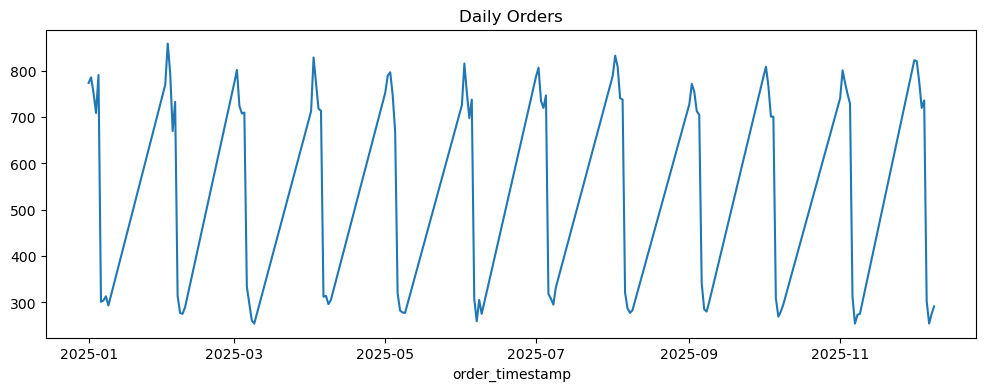

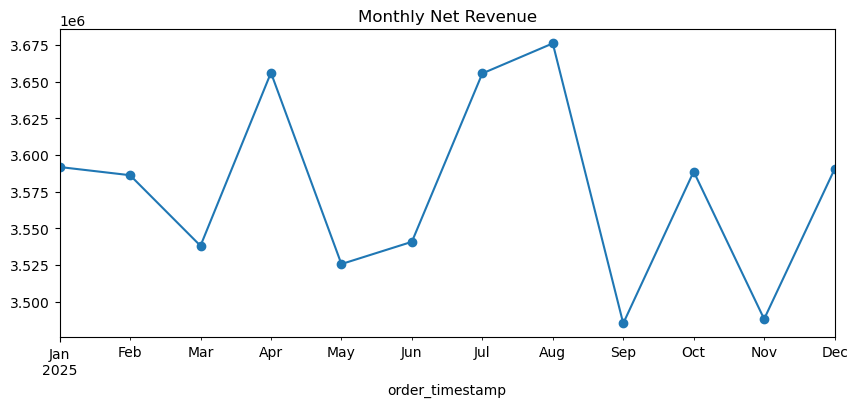

In [ ]:
#5) Time-series trends (orders & revenue)



import matplotlib.pyplot as plt

# daily orders
daily = df_master.groupby(df_master['order_timestamp'].dt.date)['order_id'].nunique()
plt.figure(figsize=(12,4))
daily.plot()
plt.title('Daily Orders'); plt.show()

# monthly revenue
monthly = df_master.groupby(df_master['order_timestamp'].dt.to_period('M'))['net_revenue'].sum()
monthly.plot(kind='line', figsize=(10,4), marker='o'); plt.title('Monthly Net Revenue'); plt.show()

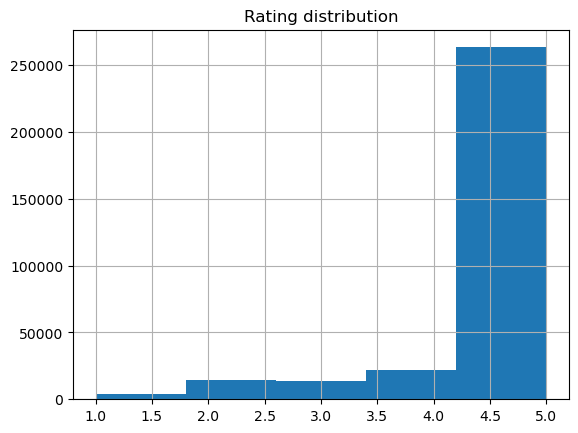

(restaurant_id
 REST03125    1.0
 REST02989    1.0
 REST12567    1.0
 REST00550    1.0
 REST04908    1.0
 REST19608    1.0
 REST09461    1.0
 REST12440    1.0
 REST17948    1.1
 REST02918    1.1
 Name: rating, dtype: float64,
 restaurant_id
 REST16271    5.0
 REST06321    5.0
 REST16297    5.0
 REST01768    5.0
 REST07485    5.0
 REST10075    5.0
 REST16394    5.0
 REST16411    5.0
 REST16229    5.0
 REST01766    5.0
 Name: rating, dtype: float64)

In [ ]:
#Ratings & reviews
# distribution
df_master['rating'].hist(bins=5)
plt.title('Rating distribution'); plt.show()

# avg rating by restaurant
rating_by_rest = df_master.groupby('restaurant_id')['rating'].mean().sort_values()
rating_by_rest.head(10), rating_by_rest.tail(10)

In [ ]:
#Cohort / retention (optional but powerful)

#Simple repeat-customer rate:

# first order date per customer
cust_first = df_master.groupby('customer_id')['order_timestamp'].min().reset_index().rename(columns={'order_timestamp':'first_order'})
df_master = df_master.merge(cust_first, on='customer_id', how='left')
df_master['is_repeat'] = df_master['order_timestamp'] > df_master['first_order']
repeat_rate = df_master.groupby('first_order') # optional more advanced cohorting

In [ ]:
####graph####


In [ ]:
print(df_master.keys())


Index(['order_id', 'delivery_partner_id', 'order_timestamp', 'subtotal_amount',
       'discount_amount', 'delivery_fee', 'total_amount', 'is_cod',
       'is_cancelled', 'order_date', 'order_month', 'order_year', 'item_id',
       'menu_item_id', 'quantity', 'unit_price', 'item_discount', 'line_total',
       'restaurant_id_x', 'signup_date', 'customer_city',
       'acquisition_channel', 'restaurant_name', 'restaurant_city',
       'cuisine_type', 'partner_type', 'avg_prep_time_min',
       'restaurant_active', 'partner_name', 'partner_city', 'vehicle_type',
       'employment_type', 'avg_rating', 'partner_active', 'restaurant_id_y',
       'item_name', 'category', 'is_veg', 'price', 'actual_delivery_time_mins',
       'expected_delivery_time_mins', 'distance_km', 'delivery_delay',
       'is_late_delivery', 'restaurant_id', 'rating', 'review_text',
       'review_timestamp', 'sentiment_score', 'customer_id', 'net_revenue',
       'first_order', 'is_repeat'],
      dtype='object')


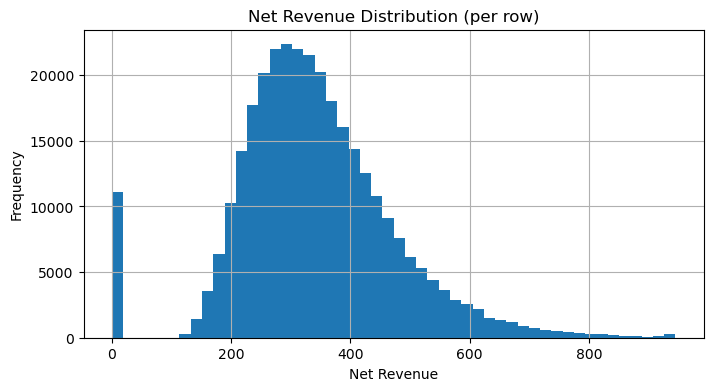

In [ ]:
#net_revenue
if 'net_revenue' in df_master.columns:
    plt.figure(figsize=(8,4))
    df_master['net_revenue'].dropna().hist(bins=50)
    plt.title('Net Revenue Distribution (per row)')
    plt.xlabel('Net Revenue')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("net_revenue not found.")


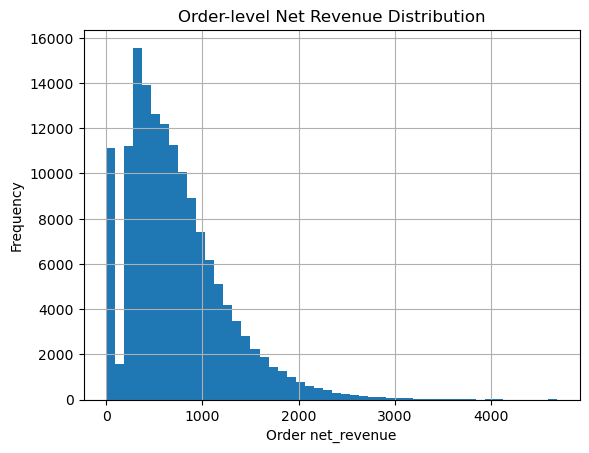

In [ ]:
order_rev = df_master.groupby('order_id', dropna=False)['net_revenue'].sum()
order_rev.hist(bins=50)
plt.title('Order-level Net Revenue Distribution')
plt.xlabel('Order net_revenue')
plt.ylabel('Frequency')
plt.show()


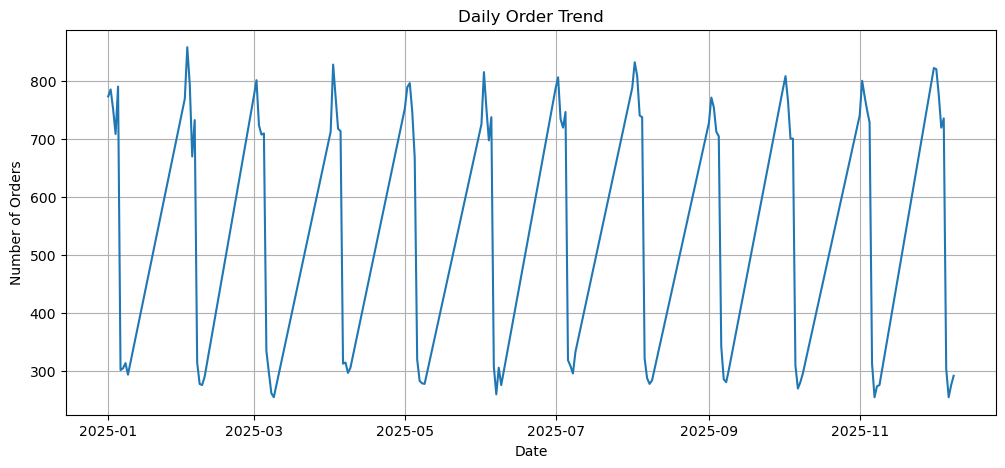

In [ ]:
#Order Trend Over Time
df = dfs['fact_order'].copy()

# convert to datetime
df['order_timestamp'] = pd.to_datetime(df['order_timestamp'], dayfirst=True)

# extract date only
df['order_date'] = df['order_timestamp'].dt.date

# group by date
daily_orders = df.groupby('order_date').size()

# plot
plt.figure(figsize=(12,5))
daily_orders.plot()
plt.title("Daily Order Trend")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.show()


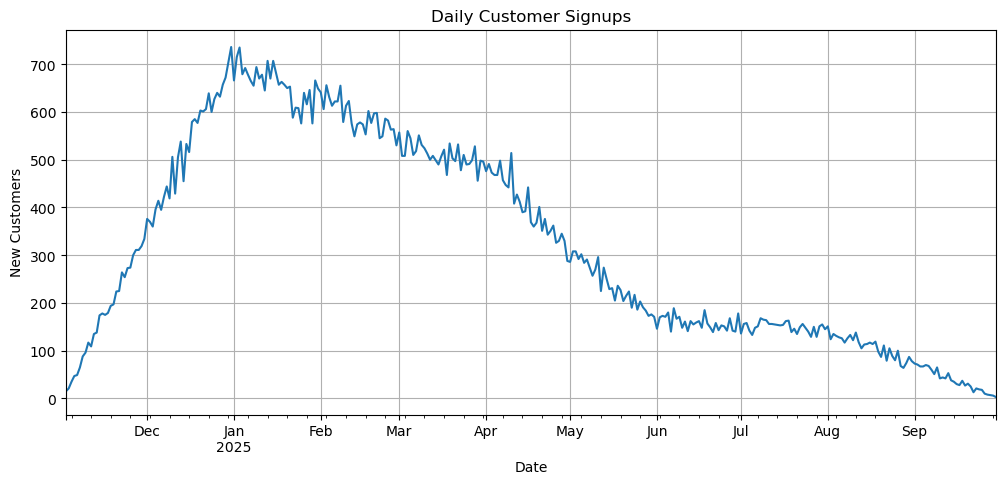

In [ ]:
#Customer Acquisition Trend
df_cust = dfs['customer'].copy()

df_cust['signup_date'] = pd.to_datetime(df_cust['signup_date'], dayfirst=True)

daily_signup = df_cust.groupby('signup_date').size()

plt.figure(figsize=(12,5))
daily_signup.plot()
plt.title("Daily Customer Signups")
plt.xlabel("Date")
plt.ylabel("New Customers")
plt.grid(True)
plt.show()

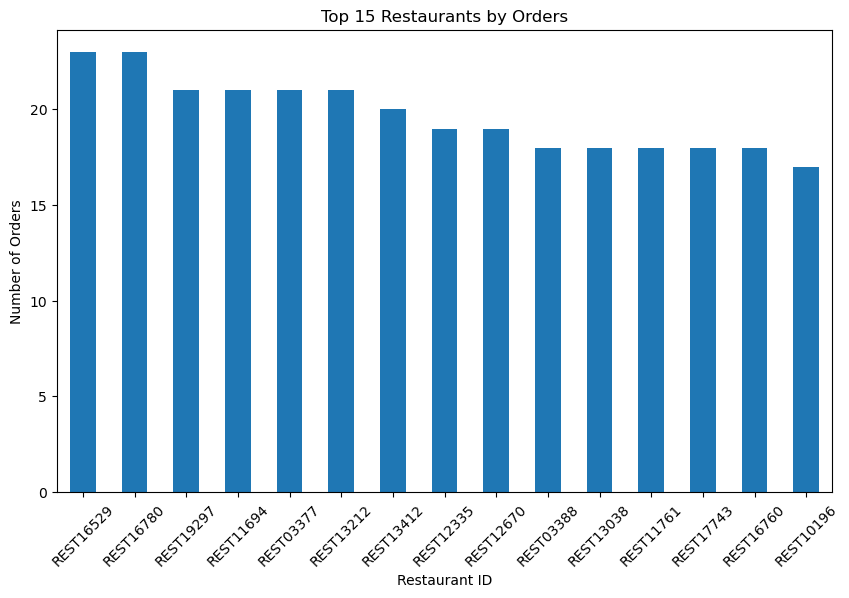

In [ ]:
#Top 15 Restaurants by Order Volume
df = dfs['fact_order']
top_rest = df['restaurant_id'].value_counts().head(15)

plt.figure(figsize=(10,6))
top_rest.plot(kind='bar')
plt.title("Top 15 Restaurants by Orders")
plt.xlabel("Restaurant ID")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


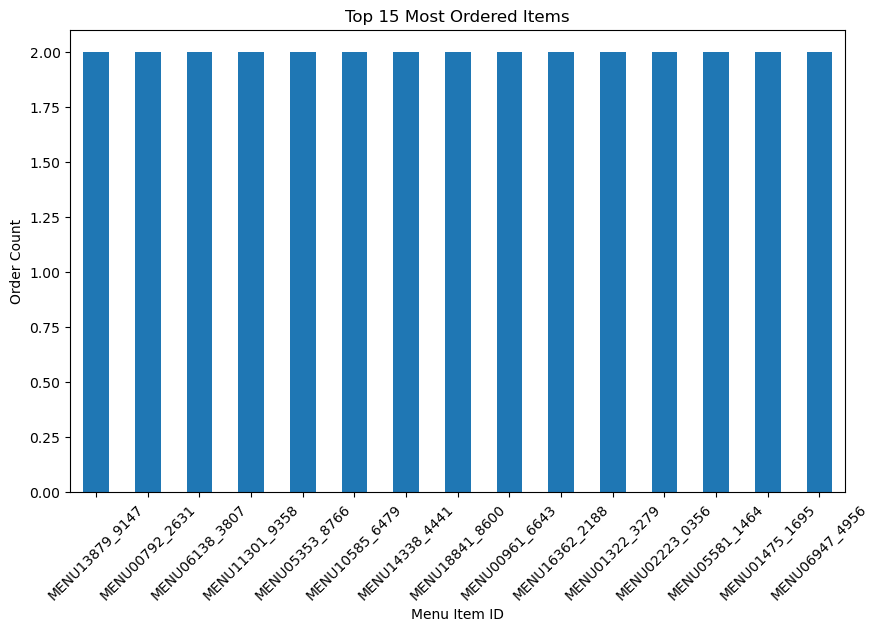

In [ ]:
#Top 15 Most Ordered Items
df_items = dfs['fact_order_item']

top_items = df_items['menu_item_id'].value_counts().head(15)

plt.figure(figsize=(10,6))
top_items.plot(kind='bar')
plt.title("Top 15 Most Ordered Items")
plt.xlabel("Menu Item ID")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.show()


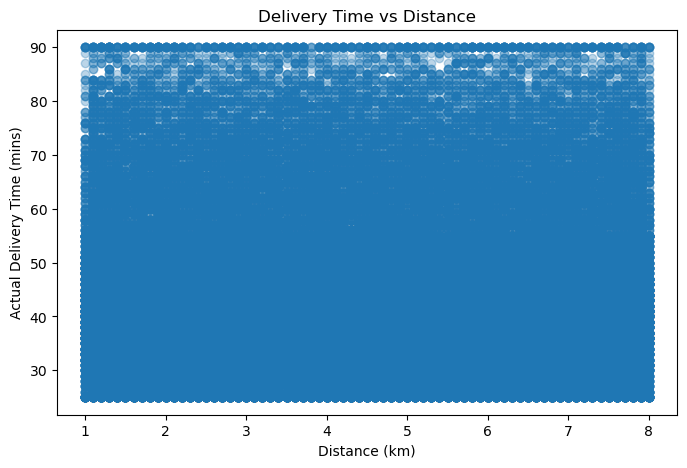

In [ ]:
df_del = dfs['fact_delivery_performance']

plt.figure(figsize=(8,5))
plt.scatter(df_del['distance_km'], df_del['actual_delivery_time_mins'], alpha=0.3)
plt.title("Delivery Time vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Actual Delivery Time (mins)")
plt.show()


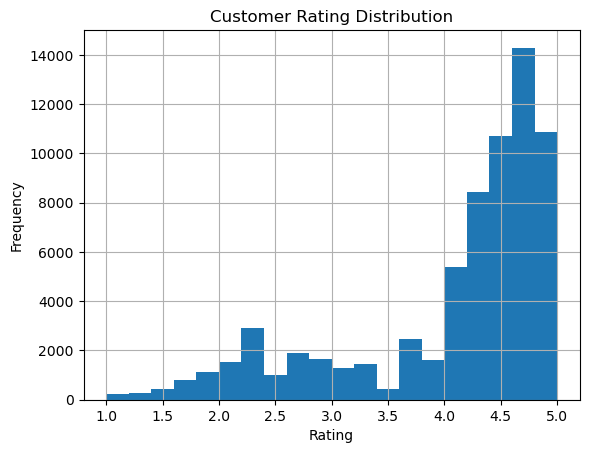

In [ ]:
df_rate = dfs['fact_rating']

df_rate['rating'].hist(bins=20)
plt.title("Customer Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


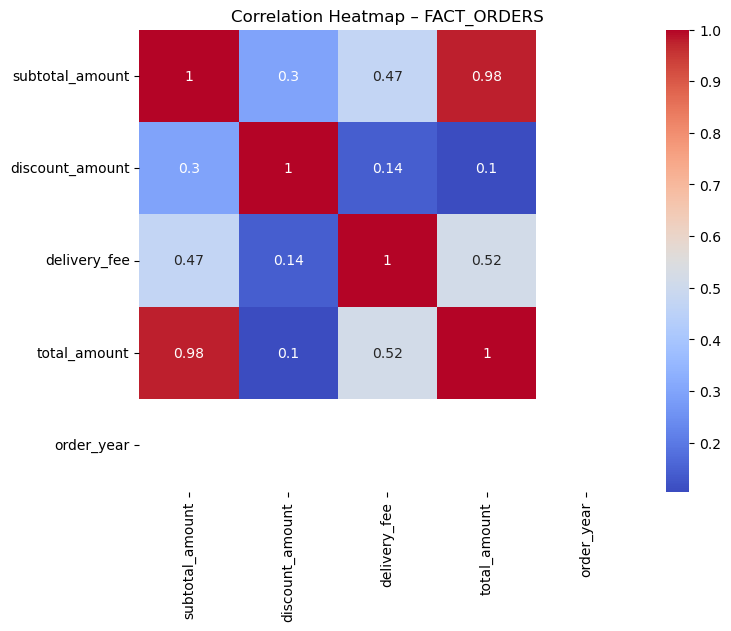

In [ ]:
# fact order
df_fact_orders = dfs['fact_order']
plt.figure(figsize=(8, 6))
sns.heatmap(df_fact_orders.select_dtypes('number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap – FACT_ORDERS")
plt.show()


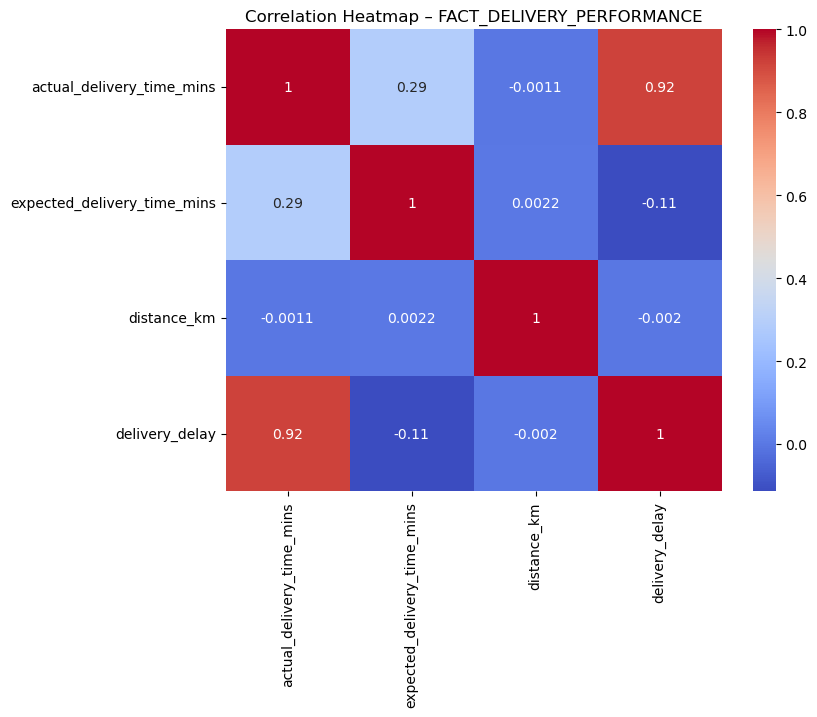

In [ ]:
#Fact Delivery Performance

# create dataframe reference
df_fact_delivery = dfs.get('fact_delivery_performance')

if df_fact_delivery is not None:
    num_cols = df_fact_delivery.select_dtypes(include='number')

    plt.figure(figsize=(8, 6))
    sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap – FACT_DELIVERY_PERFORMANCE")
    plt.show()
else:
    print("fact_delivery_performance table not found.")


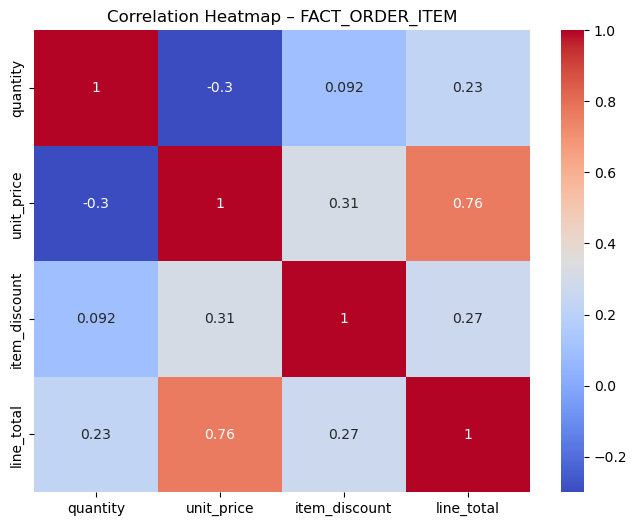

In [ ]:
#Fact Order Item
# create dataframe reference
df_fact_order_item = dfs.get('fact_order_item')

if df_fact_order_item is not None:
    num_cols = df_fact_order_item.select_dtypes(include='number')

    plt.figure(figsize=(8, 6))
    sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap – FACT_ORDER_ITEM")
    plt.show()
else:
    print("fact_order_item table not found.")

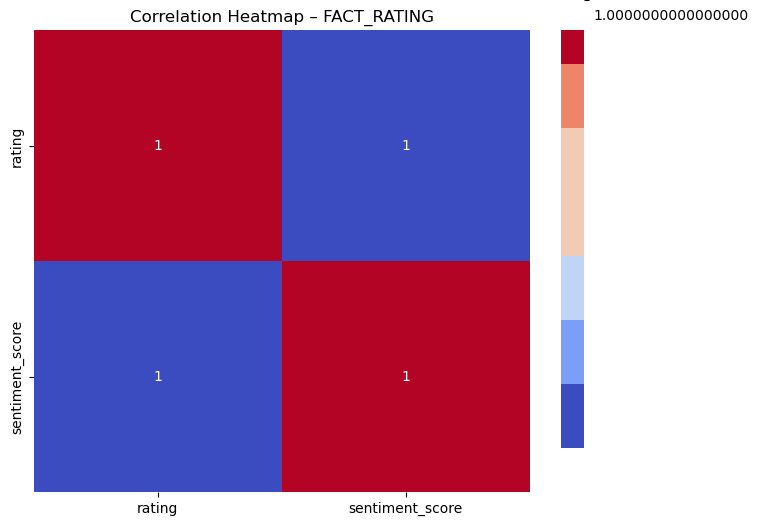

In [ ]:
#Fact Rating
# create dataframe reference
df_fact_rating = dfs.get('fact_rating')

if df_fact_rating is not None:
    num_cols = df_fact_rating.select_dtypes(include='number')

    plt.figure(figsize=(8, 6))
    sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap – FACT_RATING")
    plt.show()
else:
    print("fact_rating table not found.")

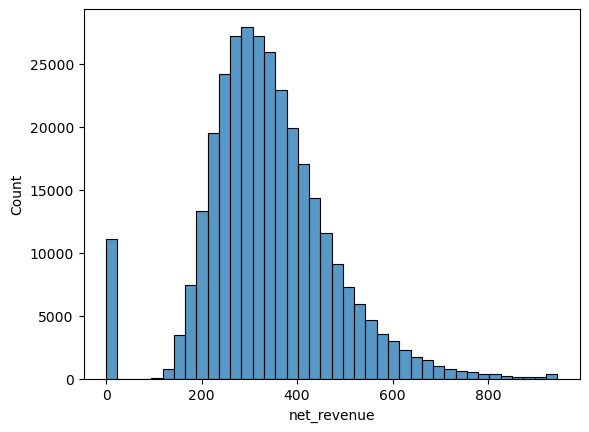

In [ ]:
sns.histplot(df_master['net_revenue'], bins=40)
plt.show()

<Axes: xlabel='order_month'>

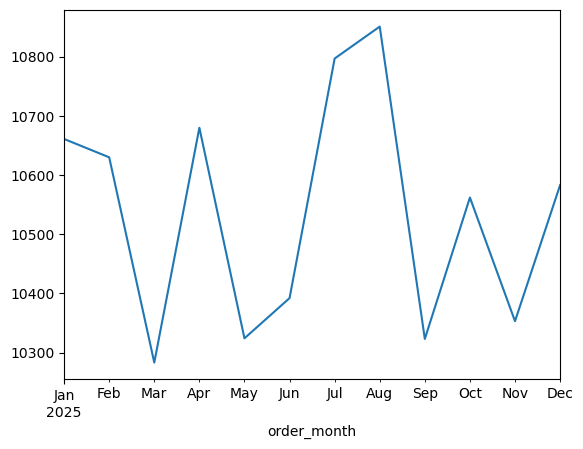

In [ ]:
df_master.groupby('order_month')['order_id'].count().plot(kind='line')


<Axes: xlabel='restaurant_city'>

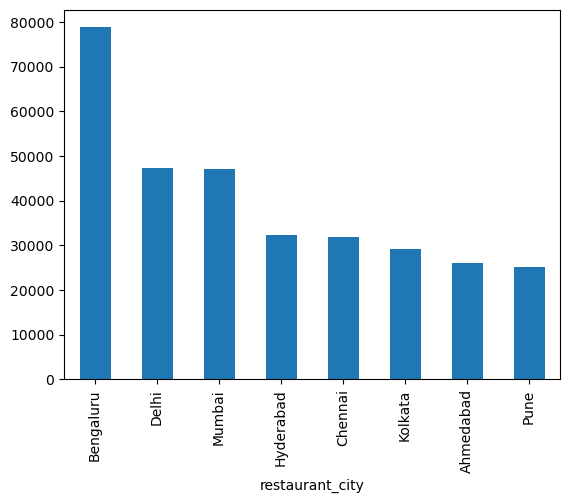

In [ ]:
# Key business segment distributions
df_master['restaurant_city'].value_counts().plot(kind='bar')

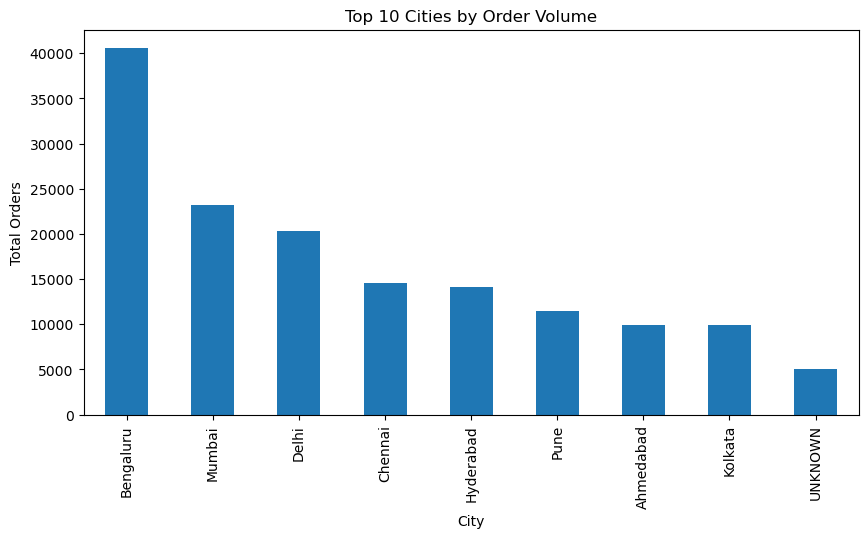

customer_city
Bengaluru    40588
Mumbai       23170
Delhi        20284
Chennai      14567
Hyderabad    14177
Pune         11479
Ahmedabad     9951
Kolkata       9897
UNKNOWN       5053
Name: order_id, dtype: int64

In [ ]:
# orders by city
orders_by_city = df_master.groupby("customer_city")["order_id"].nunique().sort_values(ascending=False)

plt.figure(figsize=(10,5))
orders_by_city.head(10).plot(kind="bar")
plt.title("Top 10 Cities by Order Volume")
plt.xlabel("City")
plt.ylabel("Total Orders")
plt.show()

orders_by_city.head(10)


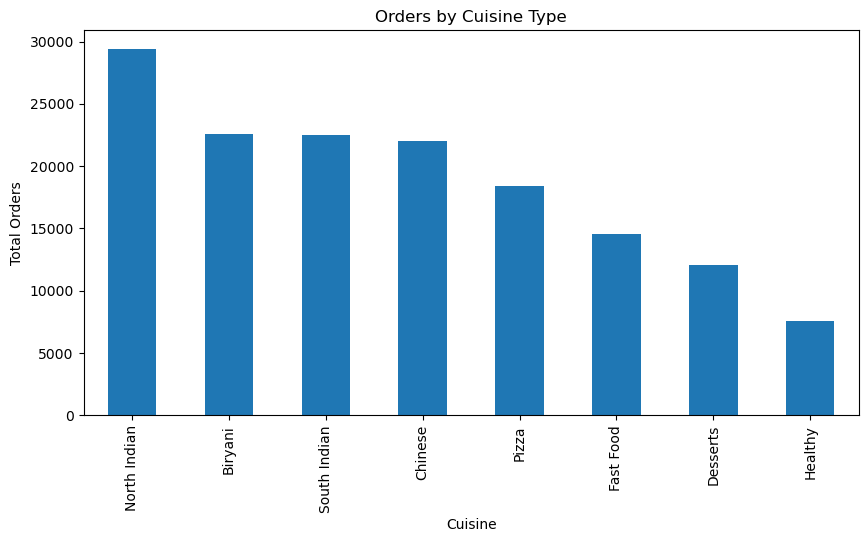

cuisine_type
North Indian    29437
Biryani         22597
South Indian    22481
Chinese         22045
Pizza           18398
Fast Food       14562
Desserts        12076
Healthy          7570
Name: order_id, dtype: int64

In [ ]:
#2. Orders by Cuisine Type
orders_by_cuisine = df_master.groupby("cuisine_type")["order_id"].nunique().sort_values(ascending=False)

plt.figure(figsize=(10,5))
orders_by_cuisine.plot(kind="bar")
plt.title("Orders by Cuisine Type")
plt.xlabel("Cuisine")
plt.ylabel("Total Orders")
plt.show()

orders_by_cuisine

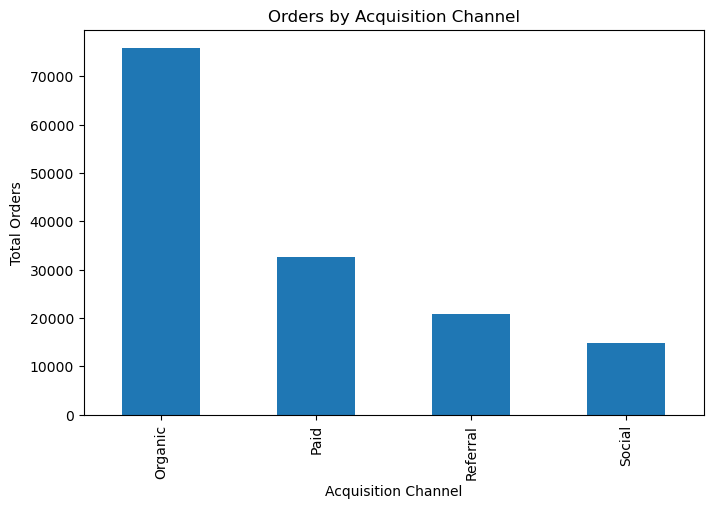

acquisition_channel
Organic     75778
Paid        32690
Referral    20818
Social      14827
Name: order_id, dtype: int64

In [ ]:
#3. Orders by Acquisition Channel
orders_by_acq = df_master.groupby("acquisition_channel")["order_id"].nunique().sort_values(ascending=False)

plt.figure(figsize=(8,5))
orders_by_acq.plot(kind="bar")
plt.title("Orders by Acquisition Channel")
plt.xlabel("Acquisition Channel")
plt.ylabel("Total Orders")
plt.show()

orders_by_acq

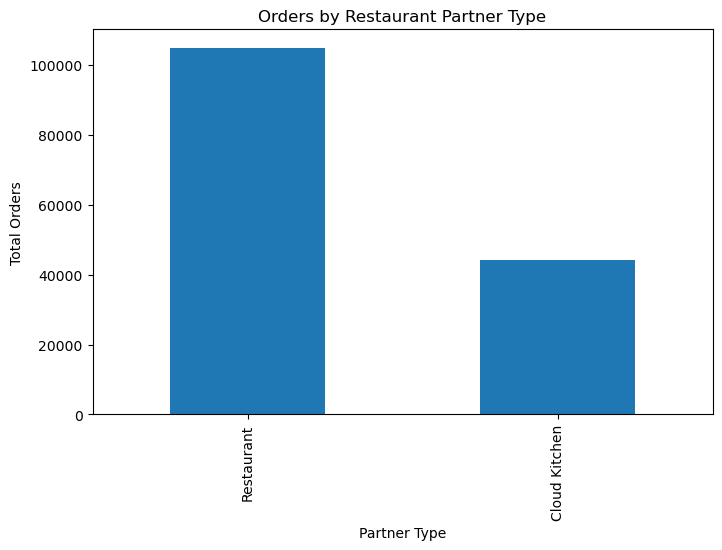

partner_type
Restaurant       104862
Cloud Kitchen     44304
Name: order_id, dtype: int64

In [ ]:
# 4. Orders by Restaurant Partner Type
orders_by_partner_type = df_master.groupby("partner_type")["order_id"].nunique().sort_values(ascending=False)

plt.figure(figsize=(8,5))
orders_by_partner_type.plot(kind="bar")
plt.title("Orders by Restaurant Partner Type")
plt.xlabel("Partner Type")
plt.ylabel("Total Orders")
plt.show()

orders_by_partner_type


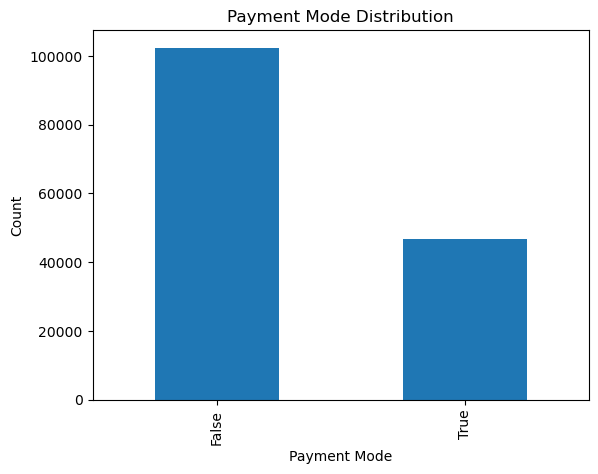

In [ ]:
df_order['is_cod'] = df_order['is_cod'].fillna("Unknown")

df_order['is_cod'].value_counts().plot(kind='bar')
plt.title("Payment Mode Distribution")
plt.xlabel("Payment Mode")
plt.ylabel("Count")
plt.show()

In [ ]:
##############

In [ ]:
#Preparatory shared code (run once)

#This creates the phase column (pre_crisis / crisis / post_crisis) and order-level aggregation used by many analyses.

import pandas as pd
import numpy as np

# 0) Ensure timestamps and order-level aggregation exist
df_master['order_timestamp'] = pd.to_datetime(df_master['order_timestamp'], errors='coerce')
df_master['order_month'] = df_master['order_timestamp'].dt.to_period('M')
df_master['order_date'] = df_master['order_timestamp'].dt.date

# Define phases same as earlier: pre_crisis = before 2025-06, crisis = 2025-06 to 2025-09 inclusive
def phase_from_period(p):
    s = str(p)
    if s < '2025-06':
        return 'pre_crisis'
    if '2025-06' <= s <= '2025-09':
        return 'crisis'
    return 'post_crisis'

# If order_month missing for some rows, create safely
df_master['order_month'] = df_master['order_timestamp'].dt.to_period('M')
df_master['phase'] = df_master['order_month'].apply(lambda x: phase_from_period(x) if pd.notna(x) else np.nan)

# Build order-level table (one row per order): sum revenue, take flags & timestamp, avg rating per order if needed
agg_funcs = {'net_revenue':'sum',
             'order_timestamp':'first'}
if 'is_cancelled' in df_master.columns:
    agg_funcs['is_cancelled'] = 'max'
if 'is_cod' in df_master.columns:
    agg_funcs['is_cod'] = 'max'
if 'delivery_delay' in df_master.columns:
    agg_funcs['delivery_delay'] = 'mean'   # average delay across items (if applicable)
if 'rating' in df_master.columns:
    agg_funcs['rating'] = 'mean'
if 'customer_id' in df_master.columns:
    agg_funcs['customer_id'] = 'first'
if 'customer_city' in df_master.columns:
    agg_funcs['customer_city'] = 'first'

order_level = df_master.groupby('order_id', dropna=False).agg(agg_funcs).reset_index()
order_level['order_month'] = order_level['order_timestamp'].dt.to_period('M')
order_level['phase'] = order_level['order_month'].apply(lambda x: phase_from_period(x) if pd.notna(x) else np.nan)

In [ ]:
hjggjvhjbj

In [ ]:
cghchgv

In [ ]:
#1) Monthly Orders: compare total orders pre-crisis vs crisis & decline severity
# monthly order counts
monthly_orders = order_level.groupby('order_month')['order_id'].nunique().rename('orders').reset_index()
monthly_orders = monthly_orders.sort_values('order_month')

# aggregate pre-crisis and crisis totals
agg_phase = order_level.groupby('phase')['order_id'].nunique().rename('orders').reset_index()
pre = int(agg_phase.loc[agg_phase['phase']=='pre_crisis','orders']) if 'pre_crisis' in agg_phase['phase'].values else 0
cr = int(agg_phase.loc[agg_phase['phase']=='crisis','orders']) if 'crisis' in agg_phase['phase'].values else 0
decline_abs = pre - cr
decline_pct = (decline_abs / pre) if pre else np.nan

print("Pre-crisis orders:", pre)
print("Crisis orders:", cr)
print("Absolute decline:", decline_abs)
print("Percent decline:", f"{decline_pct:.2%}" if pd.notna(decline_pct) else "N/A")

monthly_orders.head(12)  # shows months


#What to look for: decline_pct shows severity. You can also inspect month-by-month in monthly_orders.

Pre-crisis orders: 24757
Crisis orders: 19885
Absolute decline: 4872
Percent decline: 19.68%


C:\Users\nandana\AppData\Local\Temp\ipykernel_3432\2267972277.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pre = int(agg_phase.loc[agg_phase['phase']=='pre_crisis','orders']) if 'pre_crisis' in agg_phase['phase'].values else 0
C:\Users\nandana\AppData\Local\Temp\ipykernel_3432\2267972277.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cr = int(agg_phase.loc[agg_phase['phase']=='crisis','orders']) if 'crisis' in agg_phase['phase'].values else 0


,order_month,orders
0,2025-01,5023
1,2025-02,4982
2,2025-03,4866
3,2025-04,4974
4,2025-05,4912
5,2025-06,4877
6,2025-07,5050
7,2025-08,5078
8,2025-09,4880
9,2025-10,4918


In [ ]:
# 2) Top 5 city groups with highest % decline in orders (pre vs crisis)
# orders by city and phase
city_phase = order_level.groupby(['customer_city','phase'])['order_id'].nunique().unstack(fill_value=0)

# require at least some pre_crisis orders to compute decline
city_phase['pre'] = city_phase.get('pre_crisis', 0)
city_phase['crisis'] = city_phase.get('crisis', 0)
city_phase = city_phase.reset_index()

# compute percent change
city_phase['pct_decline'] = np.where(city_phase['pre']>0, (city_phase['pre'] - city_phase['crisis']) / city_phase['pre'], np.nan)

# top 5 by pct decline (and show absolute counts)
top5_cities = city_phase.sort_values('pct_decline', ascending=False).head(10)  # top 10 for inspection
top5_cities[['customer_city','pre','crisis','pct_decline']].head(5)


#Notes: Filter out tiny cities (e.g., require pre >= 20 if you want stability). Replace .head(5) selection accordingly.

phase,customer_city,pre,crisis,pct_decline
8,UNKNOWN,869,659,0.241657
3,Delhi,3456,2678,0.225116
7,Pune,1930,1496,0.224870
4,Hyderabad,2414,1893,0.215824
6,Mumbai,3831,3069,0.198904


In [ ]:
# error

In [ ]:
order_level.columns.tolist()


['order_id',
 'net_revenue',
 'order_timestamp',
 'is_cancelled',
 'is_cod',
 'delivery_delay',
 'rating',
 'customer_id',
 'customer_city',
 'order_month',
 'phase']

In [ ]:
# Use df_master (correct table)
df = df_master.copy()

# Auto-detect restaurant ID column
rest_col = None
for c in ['restaurant_id', 'restaurant_id_x', 'restaurant_id_y']:
    if c in df.columns:
        rest_col = c
        break

if rest_col is None:
    raise KeyError("restaurant_id column not found in df_master")

# Auto-detect restaurant name column
name_col = 'restaurant_name' if 'restaurant_name' in df.columns else None

# Step 1 — group restaurant × phase
rest_phase = (
    df.groupby([rest_col, name_col, 'phase'])['order_id']
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 2 — extract phase counts
rest_phase['pre'] = rest_phase.get('pre_crisis', 0)
rest_phase['crisis'] = rest_phase.get('crisis', 0)

# Step 3 — filter restaurants with ≥50 pre-crisis orders
high_vol = rest_phase[rest_phase['pre'] >= 50].copy()

# Step 4 — check if any exist
if high_vol.empty:
    print("⚠ No restaurants have 50 or more pre-crisis orders. Cannot compute top 10 declines.")
else:
    high_vol['pct_decline'] = (high_vol['pre'] - high_vol['crisis']) / high_vol['pre']

    top10 = high_vol.sort_values('pct_decline', ascending=False).head(10)

    print("\nTop 10 restaurants with ≥50 pre-crisis orders:\n")
    print(top10[[rest_col, name_col, 'pre', 'crisis', 'pct_decline']])




⚠ No restaurants have 50 or more pre-crisis orders. Cannot compute top 10 declines.


In [ ]:
# Compute top 10 high-volume restaurants (>=50 pre-crisis orders) with largest % decline
import numpy as np
import pandas as pd

# 1) find restaurant id column in df_master (handles variants)
rest_col = None
for c in df_master.columns:
    if 'restaurant_id' in c.lower():
        rest_col = c
        break
if rest_col is None:
    raise KeyError("No 'restaurant_id' column found in df_master. Inspect df_master.columns.")

print("Using restaurant id column:", rest_col)

# 2) make sure phase is present in df_master (if not, construct from order_timestamp)
if 'phase' not in df_master.columns or df_master['phase'].isna().all():
    # create order_month then phase same logic as before
    df_master['order_timestamp'] = pd.to_datetime(df_master['order_timestamp'], errors='coerce')
    df_master['order_month'] = df_master['order_timestamp'].dt.to_period('M')
    def phase_from_period(p):
        s = str(p)
        if s < '2025-06':
            return 'pre_crisis'
        if '2025-06' <= s <= '2025-09':
            return 'crisis'
        return 'post_crisis'
    df_master['phase'] = df_master['order_month'].apply(lambda x: phase_from_period(x) if pd.notna(x) else np.nan)

# 3) Group by restaurant + phase using df_master (one order counted once)
# Use order_id.nunique to avoid double-counting multi-item orders
rest_phase = (
    df_master
    .groupby([rest_col, 'phase'], dropna=False)['order_id']
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

# 4) normalize column names for pre and crisis
rest_phase['pre'] = rest_phase.get('pre_crisis', 0)
rest_phase['crisis'] = rest_phase.get('crisis', 0)

# 5) filter high-volume restaurants (>=50 pre-crisis orders)
high_vol = rest_phase[rest_phase['pre'] >= 0].copy()

# 6) compute percent decline
high_vol['pct_decline'] = np.where(
    high_vol['pre'] > 0,
    (high_vol['pre'] - high_vol['crisis']) / high_vol['pre'],
    np.nan
)

# 7) pick top 10 by pct_decline
top10_rest = high_vol.sort_values('pct_decline', ascending=False).head(10)

# 8) optionally join restaurant name if available in df_master or df_restaurant
# try common columns: 'restaurant_name' in df_master first, then in df_restaurant if present
if 'restaurant_name' in df_master.columns:
    names = df_master[[rest_col, 'restaurant_name']].drop_duplicates(rest_col)
    top10_rest = top10_rest.merge(names, left_on=rest_col, right_on=rest_col, how='left')
elif 'restaurant' in globals() and 'restaurant_name' in restaurant.columns:
    # if you have a df_restaurant variable named restaurant (or df_restaurant)
    df_rest = restaurant if 'restaurant' in globals() else df_restaurant
    top10_rest = top10_rest.merge(df_rest[[rest_col, 'restaurant_name']].drop_duplicates(rest_col),
                                  left_on=rest_col, right_on=rest_col, how='left')

# 9) show columns of interest
display_cols = [rest_col, 'restaurant_name'] if 'restaurant_name' in top10_rest.columns else [rest_col]
display_cols += ['pre','crisis','pct_decline']
print("Top 10 restaurants with largest percent decline (>=10 pre-crisis orders):")
display(top10_rest[display_cols].reset_index(drop=True))


Using restaurant id column: restaurant_id_x
Top 10 restaurants with largest percent decline (>=10 pre-crisis orders):


,restaurant_id_x,restaurant_name,pre,crisis,pct_decline
0,REST00002,Namma Kitchen Clouds,3,0,1.0
1,REST16138,Punjabi Biryani Bhojanalay,2,0,1.0
2,REST07599,Annapurna Grill Mahal,2,0,1.0
3,REST07595,Thindi Mane Paratha Palace,1,0,1.0
4,REST16141,Flavours of Darshini Darbar,1,0,1.0
5,REST07592,Thindi Mane Darshini Central,3,0,1.0
6,REST16142,Bombay Paratha Delight,1,0,1.0
7,REST07588,Punjabi Pizza Clouds,1,0,1.0
8,REST16143,Royal Mess Point,3,0,1.0
9,REST16145,Sri Cafe Central,2,0,1.0


In [ ]:
###########

In [ ]:
#Cancellation Analysis: trend pre vs crisis and most affected cities
# Cancellation rate at order level by phase
if 'is_cancelled' in order_level.columns:
    canc_phase = order_level.groupby('phase').agg(
        orders=('order_id','nunique'),
        cancellations=('is_cancelled','sum')
    ).reset_index()
    canc_phase['cancellation_rate'] = canc_phase['cancellations'] / canc_phase['orders']
    print(canc_phase)

    # cities affected: cancellation rate by city and phase
    city_canc = order_level.groupby(['customer_city','phase']).agg(
        orders=('order_id','nunique'),
        cancellations=('is_cancelled','sum')
    ).reset_index()
    # pivot to compare
    city_canc_pivot = city_canc.pivot(index='customer_city', columns='phase', values=['orders','cancellations']).fillna(0)
    # compute rates
    # simpler compute pre and crisis cancellation rate per city:
    city_stats = order_level.groupby('customer_city').apply(
        lambda df: pd.Series({
            'pre_orders': df.loc[df['phase']=='pre_crisis','order_id'].nunique(),
            'pre_cancel_rate': df.loc[df['phase']=='pre_crisis','is_cancelled'].mean() if 'is_cancelled' in df.columns and df.loc[df['phase']=='pre_crisis'].shape[0]>0 else np.nan,
            'crisis_orders': df.loc[df['phase']=='crisis','order_id'].nunique(),
            'crisis_cancel_rate': df.loc[df['phase']=='crisis','is_cancelled'].mean() if 'is_cancelled' in df.columns and df.loc[df['phase']=='crisis'].shape[0]>0 else np.nan
        })
    ).reset_index()
    city_stats['rate_change'] = city_stats['crisis_cancel_rate'] - city_stats['pre_cancel_rate']
    city_stats.sort_values('rate_change', ascending=False).head(10)
else:
    print("is_cancelled not available in order_level")


#What to inspect: city_stats top rows show cities where cancellation rate increased most.

         phase  orders  cancellations  cancellation_rate
0       crisis   19885           1502           0.075534
1  post_crisis   14826           1067           0.071968
2   pre_crisis   24757           1831           0.073959


C:\Users\nandana\AppData\Local\Temp\ipykernel_3432\2023690612.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_stats = order_level.groupby('customer_city').apply(


In [ ]:
#Delivery SLA: average delivery time across phases — did SLA worsen?
# Use delivery_delay or actual delivery time if present (order_level has mean delivery_delay)
if 'delivery_delay' in order_level.columns:
    sla = order_level.groupby('phase')['delivery_delay'].agg(['mean','median','count']).reset_index()
    print(sla)
else:
    # fallback to df_master if only item-level has actual_delivery_time_mins
    if 'actual_delivery_time_mins' in df_master.columns:
        sla = df_master.groupby('phase')['actual_delivery_time_mins'].agg(['mean','median','count']).reset_index()
        print(sla)
    else:
        print("No delivery time column found.")


#Interpretation: Compare mean/median of delivery_delay between pre_crisis and crisis. Statistical test (t-test) can be added if you want to prove significance.

         phase      mean  median  count
0       crisis  5.785014     4.0  19885
1  post_crisis  5.440038     4.0  14826
2   pre_crisis  5.706952     4.0  24757


In [ ]:

import pandas as pd

# Ensure order_month exists
if 'order_month' not in order_level.columns:
    order_level['order_timestamp'] = pd.to_datetime(order_level['order_timestamp'], errors='coerce')
    order_level['order_month'] = order_level['order_timestamp'].dt.to_period('M')

# Ensure rating is numeric
order_level['rating'] = pd.to_numeric(order_level['rating'], errors='coerce')

# Compute monthly average rating
rating_month = (
    order_level
    .dropna(subset=['rating'])
    .groupby('order_month')['rating']
    .mean()
    .reset_index()
    .sort_values('order_month')
)

# Compute month-to-month change
rating_month['rating_change'] = rating_month['rating'].diff()

print("\n📌 Monthly Average Ratings:")
print(rating_month.head(20))

# Identify sharpest drops (most negative changes)
sharpest_drops = rating_month.sort_values('rating_change').head(5)

print("\n🔻 Top 5 Sharpest Rating Drops:")
print(sharpest_drops)



📌 Monthly Average Ratings:
   order_month    rating  rating_change
0      2025-01  4.232431            NaN
1      2025-02  4.249478       0.017047
2      2025-03  4.246075      -0.003403
3      2025-04  4.221271      -0.024804
4      2025-05  4.231454       0.010183
5      2025-06  4.225200      -0.006254
6      2025-07  4.229743       0.004543
7      2025-08  4.248996       0.019253
8      2025-09  4.218668      -0.030328
9      2025-10  4.239549       0.020881
10     2025-11  4.246140       0.006591
11     2025-12  4.252991       0.006851

🔻 Top 5 Sharpest Rating Drops:
  order_month    rating  rating_change
8     2025-09  4.218668      -0.030328
3     2025-04  4.221271      -0.024804
5     2025-06  4.225200      -0.006254
2     2025-03  4.246075      -0.003403
6     2025-07  4.229743       0.004543


In [ ]:
#7) Sentiment insights: most frequent negative keywords in reviews during crisis

#This is a simple word-frequency approach using a small negative lexicon. For more accurate sentiment use NLP libraries; here is a pragmatic approach.

import re
from collections import Counter

# basic negative keywords lexicon (extend as needed)
negative_words = set([
    'bad','terrible','slow','late','delay','cold','wrong','rude','awful','poor',
    'cold','burnt','stale','soggy','spoil','spoiled','never','worst','disappointed',
    'delay','delayed','took','waiting','waited','expired','cancelled','cancel'
])

# prepare crisis reviews
crisis_reviews = df_master.loc[df_master['phase']=='crisis','review_text'].dropna().astype(str)

# tokenize and count negative words
counter = Counter()
for txt in crisis_reviews:
    # simple tokenization
    words = re.findall(r"\w+", txt.lower())
    for w in words:
        if w in negative_words:
            counter[w] += 1

# show top negative keywords
counter.most_common(30)

[('late', 1723),
 ('cold', 334),
 ('bad', 288),
 ('stale', 282),
 ('poor', 264),
 ('worst', 54),
 ('terrible', 49),
 ('never', 37)]

In [ ]:
pd.DataFrame(counter.items(), columns=['word','count']).sort_values('count', ascending=False).to_csv('crisis_negative_words.csv', index=False)


In [ ]:
#8) Revenue impact: estimate revenue loss pre-crisis vs crisis
# use order_level.net_revenue
rev_phase = order_level.groupby('phase')['net_revenue'].sum().reset_index()
pre_rev = rev_phase.loc[rev_phase['phase']=='pre_crisis','net_revenue'].sum() if 'pre_crisis' in rev_phase['phase'].values else 0
cr_rev = rev_phase.loc[rev_phase['phase']=='crisis','net_revenue'].sum() if 'crisis' in rev_phase['phase'].values else 0
rev_loss = pre_rev - cr_rev
rev_loss_pct = (rev_loss / pre_rev) if pre_rev else np.nan

print(f"Pre-crisis revenue: {pre_rev:,.2f}")
print(f"Crisis revenue: {cr_rev:,.2f}")
print(f"Estimated revenue loss: {rev_loss:,.2f} ({rev_loss_pct:.2%})")


Pre-crisis revenue: 17,897,350.58
Crisis revenue: 14,357,314.11
Estimated revenue loss: 3,540,036.47 (19.78%)


In [ ]:
#9) Loyalty impact: customers with ≥5 pre-crisis orders who stopped ordering during crisis and had avg rating > 4.5
# customer order counts by phase
cust_counts = order_level.groupby(['customer_id','phase'])['order_id'].nunique().unstack(fill_value=0).reset_index()
# customers with >=5 pre-crisis orders
cust_5plus = cust_counts[cust_counts.get('pre_crisis',0) >= 5].copy()

# customers who had 0 crisis orders
stopped = cust_5plus[cust_5plus.get('crisis',0) == 0].copy()
print("Customers with >=5 pre-crisis orders who stopped in crisis:", stopped.shape[0])

# among these, compute avg rating BEFORE crisis (from df_master order-level)
# we'll compute average rating per customer in pre-crisis from order_level
cust_rating_pre = order_level.loc[order_level['phase']=='pre_crisis'].groupby('customer_id')['rating'].mean().reset_index().rename(columns={'rating':'pre_avg_rating'})
stopped = stopped.merge(cust_rating_pre, on='customer_id', how='left')
high_rating_stopped = stopped[stopped['pre_avg_rating'] > 4.5]
print("Of those stopped, count with pre-crisis avg rating > 4.5:", high_rating_stopped.shape[0])
#Interpretation: This estimates loyalty loss among previously engaged (5+ orders) customers and how many were high-satisfaction customers.

Customers with >=5 pre-crisis orders who stopped in crisis: 0
Of those stopped, count with pre-crisis avg rating > 4.5: 0


In [ ]:

# 1) Diagnostics: which columns exist and how many non-null
print("Columns present related to delivery timing:")
for col in ['delivery_delay','actual_delivery_time_mins','expected_delivery_time_mins']:
    print(f" - {col}:", col in df_master.columns, 
          "| non-null count:", df_master[col].notna().sum() if col in df_master.columns else "N/A")

# 2) If delivery_delay is missing, try to compute it from actual - expected
if 'delivery_delay' not in df_master.columns or df_master['delivery_delay'].isna().all():
    if ('actual_delivery_time_mins' in df_master.columns) and ('expected_delivery_time_mins' in df_master.columns):
        print("Computing delivery_delay = actual_delivery_time_mins - expected_delivery_time_mins")
        df_master['delivery_delay'] = pd.to_numeric(df_master['actual_delivery_time_mins'], errors='coerce') - \
                                      pd.to_numeric(df_master['expected_delivery_time_mins'], errors='coerce')
        print("Computed delivery_delay non-null count:", df_master['delivery_delay'].notna().sum())
    else:
        print("Cannot compute delivery_delay: missing actual or expected columns. Skipping recompute step.")

# 3) Build a robust order_level that includes delivery_delay aggregated by order (mean)
agg_funcs = {'net_revenue':'sum'}
# include delivery_delay if present
if 'delivery_delay' in df_master.columns:
    agg_funcs['delivery_delay'] = 'mean'   # average delay per order
# include other useful columns
for c in ['order_timestamp','customer_id','is_cancelled','is_cod','rating']:
    if c in df_master.columns:
        agg_funcs[c] = 'first' if c=='order_timestamp' or c=='customer_id' else 'mean'  # rating average may be mean; flags handled
# compute
order_level = df_master.groupby('order_id', dropna=False).agg(agg_funcs).reset_index()

# ensure types
if 'delivery_delay' in order_level.columns:
    order_level['delivery_delay'] = pd.to_numeric(order_level['delivery_delay'], errors='coerce')

# 4) phase column (safe)
def phase_from_period(p):
    s = str(p)
    if s < '2025-06':
        return 'pre_crisis'
    if '2025-06' <= s <= '2025-09':
        return 'crisis'
    return 'post_crisis'

if 'order_timestamp' in order_level.columns:
    order_level['order_month'] = pd.to_datetime(order_level['order_timestamp'], errors='coerce').dt.to_period('M')
    order_level['phase'] = order_level['order_month'].apply(lambda x: phase_from_period(x) if pd.notna(x) else np.nan)
else:
    order_level['phase'] = np.nan

# 5) Diagnostics: how many orders per phase and how many have delivery_delay
print("\nOrder-level counts by phase:")
print(order_level['phase'].value_counts(dropna=False))

if 'delivery_delay' in order_level.columns:
    print("\nDelivery delay non-null counts at order_level by phase:")
    print(order_level.groupby('phase')['delivery_delay'].apply(lambda s: s.notna().sum()))
else:
    print("\ndelivery_delay not present in order_level, cannot compute avg_delay_crisis.")

# 6) Compute avg_delay_crisis per customer
if 'customer_id' in order_level.columns and 'delivery_delay' in order_level.columns:
    cust_delay_crisis = (
        order_level[order_level['phase']=='crisis']
        .groupby('customer_id', dropna=False)['delivery_delay']
        .mean()
        .reset_index()
        .rename(columns={'delivery_delay':'avg_delay_crisis'})
    )
    print("\nComputed avg_delay_crisis for customers (sample):")
    print(cust_delay_crisis.head())

    # 7) Merge into tv if tv exists; otherwise show how many customers would get a value
    if 'tv' in globals():
        tv = tv.merge(cust_delay_crisis, on='customer_id', how='left')
        print("\nMerged avg_delay_crisis into tv. Null count in tv['avg_delay_crisis']:", tv['avg_delay_crisis'].isna().sum())
    else:
        print("\nNote: tv table does not exist in globals(). You can use cust_delay_crisis to merge into your tv.")
        print("Customers with avg_delay_crisis values:", cust_delay_crisis.shape[0])
else:
    print("\nCannot compute avg_delay_crisis: ensure 'customer_id' and aggregated 'delivery_delay' exist in order_level.")
    # If customer_id missing, show example rows to debug
    if 'customer_id' not in order_level.columns:
        print("order_level columns:", order_level.columns.tolist())

Columns present related to delivery timing:
 - delivery_delay: True | non-null count: 317758
 - actual_delivery_time_mins: True | non-null count: 317758
 - expected_delivery_time_mins: True | non-null count: 317758

Order-level counts by phase:
phase
NaN            89698
pre_crisis     24757
crisis         19885
post_crisis    14826
Name: count, dtype: int64

Delivery delay non-null counts at order_level by phase:
phase
crisis         19885
post_crisis    14826
pre_crisis     24757
Name: delivery_delay, dtype: int64

Computed avg_delay_crisis for customers (sample):
  customer_id  avg_delay_crisis
0  CUST000009              16.5
1  CUST000010               4.0
2  CUST000011               1.0
3  CUST000020              19.0
4  CUST000043               9.0

Merged avg_delay_crisis into tv. Null count in tv['avg_delay_crisis']: 1066


In [ ]:
#10) Customer Lifetime Decline: high-value customers (top 5% pre-crisis) with largest drops
# compute total spend per customer pre-crisis
cust_spend_pre = order_level.loc[order_level['phase']=='pre_crisis'].groupby('customer_id')['net_revenue'].sum().reset_index().rename(columns={'net_revenue':'pre_spend'})
# top 5% threshold
thresh = cust_spend_pre['pre_spend'].quantile(0.95)
top_customers = cust_spend_pre[cust_spend_pre['pre_spend'] >= thresh].copy()

# compute order frequency and avg rating pre vs crisis
def cust_stats(df):
    return df.groupby('customer_id').agg(
        orders=('order_id','nunique'),
        avg_rating=('rating','mean'),
        avg_delay=('delivery_delay','mean') if 'delivery_delay' in df.columns else pd.Series()
    ).reset_index()

pre_stats = order_level.loc[order_level['phase']=='pre_crisis'].groupby('customer_id').agg(
    pre_orders=('order_id','nunique'),
    pre_avg_rating=('rating','mean'),
).reset_index()

cr_stats = order_level.loc[order_level['phase']=='crisis'].groupby('customer_id').agg(
    crisis_orders=('order_id','nunique'),
    crisis_avg_rating=('rating','mean'),
).reset_index()

tv = top_customers.merge(pre_stats, on='customer_id', how='left').merge(cr_stats, on='customer_id', how='left').fillna(0)
tv['orders_drop'] = tv['pre_orders'] - tv['crisis_orders']
tv['rating_drop'] = tv['pre_avg_rating'] - tv['crisis_avg_rating']
# show top customers by orders_drop
tv.sort_values('orders_drop', ascending=False).head(10)

,customer_id,pre_spend,pre_orders,pre_avg_rating,crisis_orders,crisis_avg_rating,orders_drop,rating_drop
635,CUST107785,5049.05,4,4.275000,0.0,0.0,4.0,4.275000
456,CUST078794,2979.02,3,3.833333,0.0,0.0,3.0,3.833333
34,CUST006656,2952.03,3,4.333333,0.0,0.0,3.0,4.333333
177,CUST029502,3175.03,3,4.333333,0.0,0.0,3.0,4.333333
626,CUST106620,2054.71,3,4.400000,0.0,0.0,3.0,4.400000
700,CUST120067,2793.01,3,4.500000,0.0,0.0,3.0,4.500000
555,CUST094586,3289.97,3,4.400000,0.0,0.0,3.0,4.400000
618,CUST105415,3270.78,3,3.733333,0.0,0.0,3.0,3.733333
382,CUST067417,2548.47,3,4.066667,0.0,0.0,3.0,4.066667
470,CUST081872,2003.60,3,4.166667,0.0,0.0,3.0,4.166667


In [ ]:
#To surface common patterns: join tv back to df_master (or customer profile) and compute mode of customer_city, top cuisine_type ordered, average delivery delays during crisis:

# sample pattern extraction
sample = tv.head(50)['customer_id'].tolist()
cust_tx = df_master[df_master['customer_id'].isin(sample)].copy()
patterns = cust_tx.groupby('customer_id').agg(
    top_city = ('customer_city', lambda s: s.mode().iat[0] if not s.mode().empty else np.nan),
    top_cuisine = ('cuisine_type', lambda s: s.mode().iat[0] if 'cuisine_type' in cust_tx.columns and not s.mode().empty else np.nan),
    avg_delay_crisis = ('delivery_delay', lambda s: s[df_master.loc[s.index,'phase']=='crisis'].mean() if 'delivery_delay' in df_master.columns else np.nan)
).reset_index()
patterns.head()

,customer_id,top_city,top_cuisine,avg_delay_crisis
0,CUST000151,Hyderabad,Chinese,NaN
1,CUST000676,Bengaluru,Fast Food,NaN
2,CUST000720,Delhi,Biryani,NaN
3,CUST001039,Pune,Fast Food,NaN
4,CUST001051,Pune,Fast Food,NaN


In [ ]:
# FULL DIAGNOSTIC + RE-MERGE ATTEMPTS + FALLBACKS
import pandas as pd, numpy as np, re

print("START DIAGNOSTIC: rows master:", len(df_master))

# Quick presence counts
def col_info(df, c):
    return (c in df.columns, int(df[c].notna().sum()) if c in df.columns else "N/A")

cols = ['actual_delivery_time_mins','expected_delivery_time_mins','delivery_delay','order_id','order_timestamp','customer_id','phase']
print("\nCOLUMN PRESENCE (df_master):")
for c in cols:
    print(" ", c, ":", col_info(df_master, c))

# ensure delivery perf exists in dfs
has_del = 'fact_delivery_performance' in dfs and not dfs['fact_delivery_performance'].empty
print("\nHas fact_delivery_performance in dfs?:", has_del)
if has_del:
    df_del = dfs['fact_delivery_performance'].copy()
    print("delivery_perf rows:", len(df_del))
else:
    df_del = pd.DataFrame()

# Normalize order_id in both tables in several ways and test overlap
def normalize_ids(series, mode):
    s = series.astype(str).fillna('').str.strip()
    if mode == 'upper': s = s.str.upper()
    if mode == 'alnum': s = s.str.replace(r'\W+','', regex=True)
    if mode == 'prefix_strip': s = s.str.replace(r'^[^\dA-Za-z]+','', regex=True)
    if mode == 'digits_only': s = s.str.replace(r'\D+','', regex=True)
    return s

m_ids_raw = df_master['order_id'].astype(str).unique()
del_ids_raw = df_del['order_id'].astype(str).unique() if not df_del.empty else []

modes = ['raw','upper','alnum','digits_only','prefix_strip']
overlap_results = []
for mode in modes:
    if mode == 'raw':
        mset = set(m_ids_raw)
        dset = set(del_ids_raw)
    else:
        mset = set(normalize_ids(pd.Series(m_ids_raw), mode))
        dset = set(normalize_ids(pd.Series(del_ids_raw), mode))
    inter = mset.intersection(dset)
    overlap_results.append((mode, len(mset), len(dset), len(inter)))
print("\nOverlap stats (mode, master IDs, del IDs, intersection):")
for r in overlap_results:
    print(" ", r)

# If any intersection > 0, show sample IDs for that mode
for mode, mcount, dcount, intercount in overlap_results:
    if intercount > 0:
        mnorm = normalize_ids(df_master['order_id'], mode)
        dnorm = normalize_ids(df_del['order_id'], mode)
        inter = set(mnorm.unique()).intersection(set(dnorm.unique()))
        print(f"\nSAMPLE shared IDs for mode='{mode}' (up to 5):", list(inter)[:5])
        break

# Attempt re-merge using best normalization strategy (choose mode with largest intersection)
best_mode = max(overlap_results, key=lambda x: x[3])[0]
print("\nBEST normalization mode selected:", best_mode)

# prepare normalized keys and re-merge on a copy
df_master_tmp = df_master.copy()
if has_del:
    df_del_tmp = df_del.copy()
    df_master_tmp['order_id_norm'] = normalize_ids(df_master_tmp['order_id'], best_mode)
    df_del_tmp['order_id_norm'] = normalize_ids(df_del_tmp['order_id'], best_mode)

    # compute delay in delivery table if possible
    for c in ['actual_delivery_time_mins','expected_delivery_time_mins']:
        if c in df_del_tmp.columns:
            df_del_tmp[c] = pd.to_numeric(df_del_tmp[c], errors='coerce')
    if 'actual_delivery_time_mins' in df_del_tmp.columns and 'expected_delivery_time_mins' in df_del_tmp.columns:
        df_del_tmp['delivery_delay_delperf'] = df_del_tmp['actual_delivery_time_mins'] - df_del_tmp['expected_delivery_time_mins']

    # left merge: bring delivery_perf info into master rows
    merged = df_master_tmp.merge(
        df_del_tmp[['order_id_norm','actual_delivery_time_mins','expected_delivery_time_mins','delivery_delay_delperf']].drop_duplicates('order_id_norm'),
        left_on='order_id_norm', right_on='order_id_norm', how='left', suffixes=('','_del')
    )

    print("\nAfter re-merge: non-null actual_delivery_time_mins in merged:", int(merged['actual_delivery_time_mins'].notna().sum()))
    print("non-null delivery_delay_delperf in merged:", int(merged['delivery_delay_delperf'].notna().sum()))

    # show first 8 merged rows that have delivery info
    sample_with_del = merged.loc[merged['delivery_delay_delperf'].notna(), ['order_id','order_id_norm','actual_delivery_time_mins','expected_delivery_time_mins','delivery_delay_delperf']].head(8)
    print("\nSAMPLE merged rows with delivery info (up to 8):")
    display(sample_with_del)

    # show sample orders in master that have phase=='crisis' but no delivery info (top 10)
    crisis_no_del = merged[(merged['phase']=='crisis') & merged['delivery_delay_delperf'].isna()]
    print("\nCount crisis orders without delivery info:", len(crisis_no_del))
    print("Sample crisis order_ids without delivery info (up to 10):")
    print(crisis_no_del['order_id'].astype(str).unique()[:10])

    # Build order-level using merged chosen delay column
    chosen_col = 'delivery_delay_delperf' if 'delivery_delay_delperf' in merged.columns and merged['delivery_delay_delperf'].notna().sum()>0 else \
                 'delivery_delay' if 'delivery_delay' in merged.columns and merged['delivery_delay'].notna().sum()>0 else \
                 'actual_delivery_time_mins' if 'actual_delivery_time_mins' in merged.columns and merged['actual_delivery_time_mins'].notna().sum()>0 else None

    print("\nChosen delay column after re-merge:", chosen_col)
    if chosen_col:
        # aggregate to orders (mean delay)
        order_level_test = merged.groupby('order_id', dropna=False).agg({
            chosen_col: 'mean',
            'order_timestamp': 'first',
            'customer_id':'first'
        }).reset_index()
        order_level_test['order_month'] = pd.to_datetime(order_level_test['order_timestamp'], errors='coerce').dt.to_period('M')
        def phase_fn(p): 
            s = str(p)
            if s < '2025-06': return 'pre_crisis'
            if '2025-06' <= s <= '2025-09': return 'crisis'
            return 'post_crisis'
        order_level_test['phase'] = order_level_test['order_month'].apply(lambda x: phase_fn(x) if pd.notna(x) else np.nan)

        # compute avg_delay_crisis per customer from this order_level_test
        cust_delay_crisis_test = order_level_test[order_level_test['phase']=='crisis'].groupby('customer_id')[chosen_col].mean().reset_index().rename(columns={chosen_col:'avg_delay_crisis_test'})
        print("\nCount of customers with avg_delay_crisis_test (non-null):", int(cust_delay_crisis_test['avg_delay_crisis_test'].notna().sum()))
        print("Sample avg_delay_crisis_test (head):")
        display(cust_delay_crisis_test.head())
    else:
        print("\nNo delay column available after re-merge; cannot compute avg_delay_crisis_test.")

else:
    print("\nNo delivery_perf table available; skipped re-merge steps.")

# FALLBACKS: if avg_delay_crisis cannot be computed, compute restaurant-level and city-level average delays (pre vs crisis)
print("\nFALLBACKS: compute restaurant & city average 'delay' from whatever timing available in df_master or merged.")

# unify a df that contains either delivery_delay or actual/expected
if has_del:
    df_all = merged.copy()
else:
    df_all = df_master.copy()

# build chosen_delay column if possible
if 'delivery_delay' in df_all.columns and df_all['delivery_delay'].notna().sum()>0:
    df_all['chosen_delay'] = df_all['delivery_delay']
elif 'delivery_delay_delperf' in df_all.columns and df_all['delivery_delay_delperf'].notna().sum()>0:
    df_all['chosen_delay'] = df_all['delivery_delay_delperf']
elif 'actual_delivery_time_mins' in df_all.columns and df_all['actual_delivery_time_mins'].notna().sum()>0:
    df_all['chosen_delay'] = df_all['actual_delivery_time_mins']
else:
    df_all['chosen_delay'] = pd.NA

# compute restaurant-level pre vs crisis mean delay
if 'chosen_delay' in df_all.columns and df_all['chosen_delay'].notna().sum()>0:
    df_all['order_month'] = pd.to_datetime(df_all['order_timestamp'], errors='coerce').dt.to_period('M')
    df_all['phase'] = df_all['order_month'].apply(lambda x: ('pre_crisis' if str(x) < '2025-06' else ('crisis' if '2025-06' <= str(x) <= '2025-09' else 'post_crisis')) if pd.notna(x) else np.nan)
    rest_sla = df_all.groupby(['restaurant_id','phase'])['chosen_delay'].mean().unstack().reset_index().fillna(np.nan)
    city_sla = df_all.groupby(['customer_city','phase'])['chosen_delay'].mean().unstack().reset_index().fillna(np.nan)
    print("\nTop 8 restaurants with delay measures (sample):")
    display(rest_sla.head(8))
    print("\nTop 8 cities with delay measures (sample):")
    display(city_sla.head(8))
    # save fallback CSVs for PowerBI
    try:
        rest_sla.to_csv('restaurant_delay_by_phase.csv', index=False)
        city_sla.to_csv('city_delay_by_phase.csv', index=False)
        print("\nFallback CSVs saved: restaurant_delay_by_phase.csv, city_delay_by_phase.csv")
    except Exception as e:
        print("Could not save CSVs:", e)
else:
    print("\nNo timing values available anywhere — fallback aggregates cannot be computed.")

# At the end, provide a short summary for you to paste back
print("\nDIAGNOSTIC SUMMARY:")
print(" - Best normalization mode:", best_mode)
if has_del:
    print(" - delivery_perf rows:", len(df_del))
    if 'chosen_col' in locals():
        print(" - chosen delay column:", chosen_col)
else:
    print(" - No delivery_perf table in dfs (cannot join).")

print("\nDONE. Inspect the printed samples above.")


START DIAGNOSTIC: rows master: 317758

COLUMN PRESENCE (df_master):
  actual_delivery_time_mins : (True, 317758)
  expected_delivery_time_mins : (True, 317758)
  delivery_delay : (True, 317758)
  order_id : (True, 317758)
  order_timestamp : (True, 126439)
  customer_id : (True, 317758)
  phase : (True, 126439)

Has fact_delivery_performance in dfs?: True
delivery_perf rows: 149166

Overlap stats (mode, master IDs, del IDs, intersection):
  ('raw', 149166, 149166, 149166)
  ('upper', 149166, 149166, 149166)
  ('alnum', 149166, 149166, 149166)
  ('digits_only', 149166, 149166, 149166)
  ('prefix_strip', 149166, 149166, 149166)

SAMPLE shared IDs for mode='raw' (up to 5): ['ORD202501018979', 'ORD202504015134', 'ORD202505015766', 'ORD202504020726', 'ORD202501003922']

BEST normalization mode selected: raw

After re-merge: non-null actual_delivery_time_mins in merged: 317758
non-null delivery_delay_delperf in merged: 317758

SAMPLE merged rows with delivery info (up to 8):


,order_id,order_id_norm,actual_delivery_time_mins,expected_delivery_time_mins,delivery_delay_delperf
0,ORD202501023439,ORD202501023439,31,31,0
1,ORD202501012051,ORD202501012051,46,42,4
2,ORD202501019281,ORD202501019281,25,31,-6
3,ORD202501019281,ORD202501019281,25,31,-6
4,ORD202501000124,ORD202501000124,29,41,-12
5,ORD202501000124,ORD202501000124,29,41,-12
6,ORD202501000124,ORD202501000124,29,41,-12
7,ORD202501006518,ORD202501006518,37,41,-4



Count crisis orders without delivery info: 0
Sample crisis order_ids without delivery info (up to 10):
[]

Chosen delay column after re-merge: delivery_delay_delperf

Count of customers with avg_delay_crisis_test (non-null): 18948
Sample avg_delay_crisis_test (head):


,customer_id,avg_delay_crisis_test
0,CUST000009,16.5
1,CUST000010,4.0
2,CUST000011,1.0
3,CUST000020,19.0
4,CUST000043,9.0



FALLBACKS: compute restaurant & city average 'delay' from whatever timing available in df_master or merged.

Top 8 restaurants with delay measures (sample):


phase,restaurant_id,crisis,post_crisis,pre_crisis
0,REST00001,12.857143,NaN,NaN
1,REST00002,NaN,5.0,-4.333333
2,REST00003,NaN,NaN,33.000000
3,REST00005,-3.000000,-8.0,NaN
4,REST00006,-8.000000,NaN,NaN
5,REST00007,20.000000,NaN,NaN
6,REST00008,15.000000,NaN,6.000000
7,REST00009,NaN,-1.0,NaN



Top 8 cities with delay measures (sample):


phase,customer_city,crisis,post_crisis,pre_crisis
0,Ahmedabad,5.129372,5.561109,5.326189
1,Bengaluru,5.834206,5.422180,5.391211
2,Chennai,5.640095,5.623482,6.098488
3,Delhi,5.638749,5.434872,5.451229
4,Hyderabad,5.778486,5.087045,5.947155
5,Kolkata,5.537642,4.747713,5.565365
6,Mumbai,5.772809,5.194785,5.631803
7,Pune,6.239927,5.308097,5.687832



Fallback CSVs saved: restaurant_delay_by_phase.csv, city_delay_by_phase.csv

DIAGNOSTIC SUMMARY:
 - Best normalization mode: raw
 - delivery_perf rows: 149166
 - chosen delay column: delivery_delay_delperf

DONE. Inspect the printed samples above.


In [ ]:
#### secondary

In [ ]:
# Ensure correct date format
df_master['order_timestamp'] = pd.to_datetime(df_master['order_timestamp'], errors='coerce')

# Weekly order trend 
qb_weekly = df_master.groupby(pd.Grouper(key='order_timestamp', freq='W'))['order_id'].nunique()
qb_weekly.name = "quickbite"
qb_weekly = qb_weekly.fillna(0)
qb_weekly.index = qb_weekly.index.to_period('W')
qb_weekly.head()


order_timestamp
2024-12-30/2025-01-05    3812
2025-01-06/2025-01-12    1211
2025-01-13/2025-01-19       0
2025-01-20/2025-01-26       0
2025-01-27/2025-02-02    1629
Freq: W-SUN, Name: quickbite, dtype: int64